# Sentiment Analysis of Baldur's Gate 3 Steam Reviews

In this notebook, we will perform sentiment analysis on the reviews of Baldur's Gate 3 obtained from [this Kaggle dataset](https://www.kaggle.com/datasets/harisyafie/baldurs-gate-3-steam-reviews/data). The process involves preparing the dataset, preprocessing the reviews, and using machine learning models to classify the sentiment of each review.

The goal is to train models that can accurately classify each review into the correct sentiment category. We will evaluate the models' performance and measure their efficiency in sentiment classification.

The machine learning models we will use for this task are:
- Logistic Regression
- SGD Classifier
- Naive Bayes

Firstly, we have to import the necessary libraries

*Tip: You might need to install some packages with the pip installer to import all the libraries*

In [1]:
# basic data handling and math libraries
import numpy as np
import pandas as pd
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [2]:
#Natural Language Processing libraries
import re # regular expressions and string manipulation libraries
import nltk
from nltk.stem import WordNetLemmatizer, WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer

In [3]:
# Scikit-learn libraries for feature extraction and modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

In [4]:
# for saving models and ignoring warnings because they are annoying
import joblib # for saving models, How to use?: joblib.dump(model, 'model.pkl'), joblib.load('model.pkl')
# to ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')
# To count the time
from datetime import datetime

In [101]:
from time import perf_counter

### For the first step, we are gonna import the data that we created in the previous notebook, in **DataFrame** format

In [6]:
BG3_df = pd.read_csv('BG3_reviews_updated.csv')
BG3_df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,written_during_early_access,comment_count,steam_purchase,received_for_free
0,153560814,english,This game hits all the right marks. 10/10,1702542971,1702542971,True,0,0,0.0,False,0,True,False
1,153560623,english,took me like 11 hours to understand the basics,1702542657,1702542657,True,0,0,0.0,False,0,True,False
2,153560414,english,10/10 game play and story! It's my first turn ...,1702542275,1702542275,True,0,0,0.0,False,0,True,False
3,153560343,english,gale is so baby girl,1702542158,1702542158,True,0,0,0.0,False,0,True,False
4,153559963,english,"YES,\n\nWITHOUT A F****N DOUBT.",1702541518,1702541518,True,0,0,0.0,False,0,True,False


## **Exploratory Data Analysis (EDA)**

### Dataset Overview
The `info()` method provides an overview of the dataset, including column names, data types, and missing values.

In [7]:
BG3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309103 entries, 0 to 309102
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   recommendationid             309103 non-null  int64  
 1   language                     309103 non-null  object 
 2   review                       308086 non-null  object 
 3   timestamp_created            309103 non-null  int64  
 4   timestamp_updated            309103 non-null  int64  
 5   voted_up                     309103 non-null  bool   
 6   votes_up                     309103 non-null  int64  
 7   votes_funny                  309103 non-null  int64  
 8   weighted_vote_score          309103 non-null  float64
 9   written_during_early_access  309103 non-null  bool   
 10  comment_count                309103 non-null  int64  
 11  steam_purchase               309103 non-null  bool   
 12  received_for_free            309103 non-null  bool   
dtyp

### Dataset Summary Statistics

Using the `describe()` method, we generate statistics for the numerical columns in the dataset:
- Count of values.
- Mean, standard deviation, minimum, and maximum values.
- Quartiles (25th, 50th, and 75th percentiles).

In [8]:
BG3_df.describe()

,recommendationid,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count
count,3.091030e+05,3.091030e+05,3.091030e+05,309103.000000,309103.000000,309103.000000,309103.000000
mean,1.395002e+08,1.685487e+09,1.687336e+09,1.728039,0.330246,0.113663,0.040847
std,1.968931e+07,2.638019e+07,2.435857e+07,74.091999,16.044067,0.213798,1.734666
min,7.713630e+07,1.602005e+09,1.602005e+09,0.000000,0.000000,0.000000,0.000000
25%,1.436647e+08,1.691514e+09,1.691665e+09,0.000000,0.000000,0.000000,0.000000
50%,1.449658e+08,1.692943e+09,1.693192e+09,0.000000,0.000000,0.000000,0.000000
75%,1.479757e+08,1.696946e+09,1.698381e+09,1.000000,0.000000,0.000000,0.000000
max,1.535608e+08,1.702543e+09,1.702554e+09,15728.000000,3970.000000,0.984480,592.000000


### Distribution of Sentiments in the Dataset

We use the `value_counts()` method on the `voted_up` column.

In [9]:
BG3_df['voted_up'].value_counts()

voted_up
True     298932
False     10171
Name: count, dtype: int64

There is imbalance in the dataset

### Missing Values

The `isnull().sum()` method reveals missing values:

- The `review` column has 1,017 missing values.
- All other columns have no missing values.

In [10]:
BG3_df.isnull().sum()

recommendationid                  0
language                          0
review                         1017
timestamp_created                 0
timestamp_updated                 0
voted_up                          0
votes_up                          0
votes_funny                       0
weighted_vote_score               0
written_during_early_access       0
comment_count                     0
steam_purchase                    0
received_for_free                 0
dtype: int64

### Handling Missing Values
The rows with missing values are dropped using `dropna()`. `isnull().sum()` confirms there are no more missing values in the dataset.

In [11]:
# Drop the rows with missing values
BG3_df.dropna(inplace=True)

BG3_df.isnull().sum()

recommendationid               0
language                       0
review                         0
timestamp_created              0
timestamp_updated              0
voted_up                       0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
written_during_early_access    0
comment_count                  0
steam_purchase                 0
received_for_free              0
dtype: int64

### Selecting and Preparing Dataset Columns

In this step, we select the relevant columns from the dataset: `review` (the review text) and `voted_up` (indicating whether the user recommends the game or not). 

- The `voted_up` column is transformed into a binary format where:
  - `1` represents the review recommending the game.
  - `0` represents the review not recommending.
  
Finally, we check the distribution of values in the `voted_up` column to understand the balance between positive and negative reviews.

In [12]:
df_2cols = BG3_df[['review', 'voted_up']]
df_2cols['voted_up'] = BG3_df['voted_up'].apply(lambda x: 1 if x == True else 0)
df_2cols['voted_up'].value_counts()

voted_up
1    297929
0     10157
Name: count, dtype: int64

### Balancing the Dataset
To address the class imbalance:
- The majority class (`voted_up = 1`) is downsampled to match the minority class (`voted_up = 0`) with **10.157** samples.
- The two classes are combined, and the data is shuffled.

In [14]:
# Resampling to balance the dataset and mix the data
df_majority = df_2cols[df_2cols['voted_up'] == 1]
df_minority = df_2cols[df_2cols['voted_up'] == 0]

df_majority_downsampled = resample(df_majority, replace=True, n_samples=10157, random_state=123)

df = pd.concat([df_majority_downsampled, df_minority])

# Mixing the data
df = df.sample(frac=1).reset_index(drop=True)

df['voted_up'].value_counts()

voted_up
1    10157
0    10157
Name: count, dtype: int64

### Dataset Structure After Balancing
The `info()` method confirms the updated dataset.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20314 entries, 0 to 20313
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    20314 non-null  object
 1   voted_up  20314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 317.5+ KB


## **Removing capital letters and special characters**
### We need to clean the DataFrame for further processing which will ensure that the data is  free of unneccesary noise.

### Removing special characters
(digits are optional, we have set it `True`)

In [16]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-Z\s]' if remove_digits else r'[^a-zA-Z0-9\s]'
    return re.sub(pattern, '', text)

df['review'] = df['review'].apply(lambda x: remove_special_characters(x))

### Converting into lowercase the text data in the 'review' column

In [17]:
# Lowercase all text
df['review'] = df['review'].apply(lambda x: x.lower())

## **Text Normalization**

### Tokenizing the text data
The `ToktokTokenizer` is a simple, general tokenizer, where the input has one sentence per line; thus only final period is tokenized.

In [18]:
# Tokenization with nltk
tokenizer = ToktokTokenizer()
df['review'] = df['review'].apply(lambda x: tokenizer.tokenize(x))

# displaying the first 5 rows of the content column
df['review'].head()

0    [i, do, not, like, crpgs, or, fantasy, setting...
1                                           [is, good]
2    [brief, background, dos, is, one, of, my, favo...
3                                                 [ok]
4    [i, genuinely, dont, understand, the, hype, th...
Name: review, dtype: object

### Removing Stopwords
Stopwords in English are filtered out using NLTK's predefined stopword list. Words like "no" and "not" are retained as they are important for sentiment analysis. The updated stopword list is printed for confirmation.

In [19]:
# removing english stopowrds with nltk
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

### Removing Stopwords from Reviews
A new column, `without_stopwords`, is created by removing stopwords from the tokenized text in the `review` column.
The first 5 rows of the updated column are displayed to verify the process.

In [20]:
# creating a new column with the text data without stopwords
df['without_stopwords'] = df['review'].apply(lambda x: [word for word in x if word not in stopword_list])

# printing the first 5 rows of the content column
df['without_stopwords'].head()

0    [not, like, crpgs, fantasy, setting, games, ga...
1                                               [good]
2    [brief, background, dos, one, favorite, games,...
3                                                 [ok]
4    [genuinely, dont, understand, hype, game, gett...
Name: without_stopwords, dtype: object

### Lemmatization of Reviews
The `lemmatized` column is created by applying lemmatization to the text using NLTK's WordNetLemmatizer. Lemmatization reduces words to their base or root form.
The first 5 rows of the lemmatized column are displayed to confirm the process.

In [21]:
# lemmatization with nltk
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['without_stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# printing the first 5 rows of the content column
df['lemmatized'].head()

0    [not, like, crpgs, fantasy, setting, game, gam...
1                                               [good]
2    [brief, background, do, one, favorite, game, t...
3                                                 [ok]
4    [genuinely, dont, understand, hype, game, gett...
Name: lemmatized, dtype: object

### Comparing Preprocessing Steps
A sample review is printed at each stage to observe the effects of preprocessing

In [22]:
print(f"Original text sample:             {df['review'][0]}\n")
print(f"Text sample without stopwords:    {df['without_stopwords'][0]}\n")
print(f"Text sample lemmatized:           {df['lemmatized'][0]}\n")

Original text sample:             ['i', 'do', 'not', 'like', 'crpgs', 'or', 'fantasy', 'setting', 'games', 'this', 'is', 'my', 'game', 'of', 'the', 'year', 'for', 'too', 'many', 'reasons', 'to', 'list']

Text sample without stopwords:    ['not', 'like', 'crpgs', 'fantasy', 'setting', 'games', 'game', 'year', 'many', 'reasons', 'list']

Text sample lemmatized:           ['not', 'like', 'crpgs', 'fantasy', 'setting', 'game', 'game', 'year', 'many', 'reason', 'list']



### Saving the Preprocessed Dataset
The cleaned and preprocessed dataset is saved to a CSV file named `BG3_Cleaned.csv`. The `index=False` parameter ensures that the index column is not included in the saved file. This allows for easy reuse of the processed data.

In [23]:
df.to_csv('BG3_Cleaned.csv', index=False)

## Visualizing Word Frequencies with Word Clouds
Word clouds are generated to visualize the most frequent words in the dataset at different preprocessing stages. These visualizations help in understanding the prominent terms in the reviews and how preprocessing refines the text data.

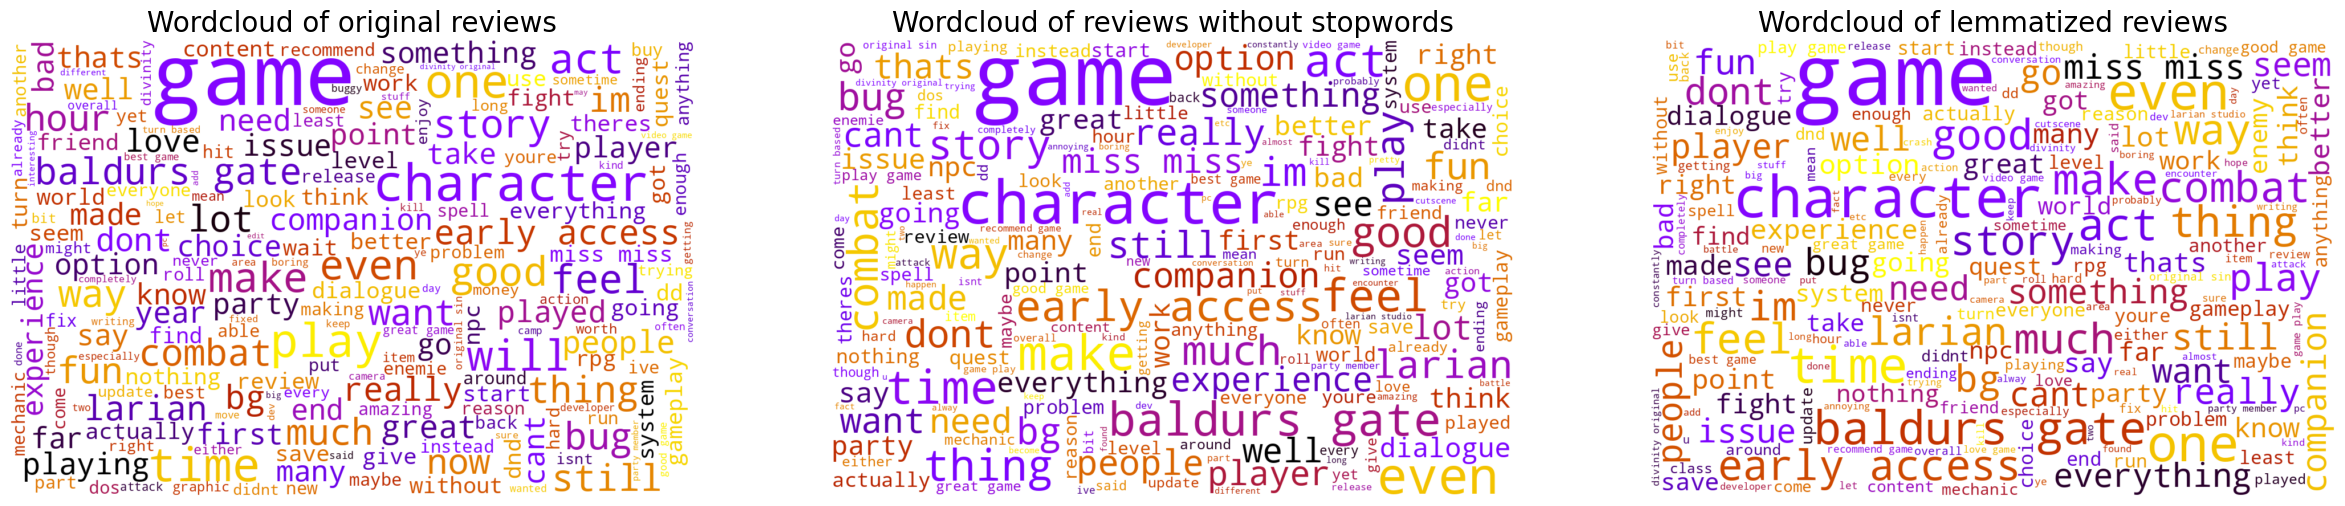

In [24]:
# Joining all the  reviews into a single string
all_reviews = " ".join([" ".join(review) for review in df['review']])
all_reviews_without_stopwords = " ".join([" ".join(review) for review in df['without_stopwords']])
all_reviews_lemmatized = " ".join([" ".join(review) for review in df['lemmatized']])


# Plotting the wordclouds
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

# For original reviews
wordcloud1 = WordCloud(width = 1200, height = 800, random_state=42, max_font_size=150, background_color='#FFFFFF', colormap = 'gnuplot_r').generate(all_reviews)
ax1.imshow(wordcloud1, interpolation="bilinear")
ax1.axis('off')
ax1.set_title('Wordcloud of original reviews', fontsize=20)

# For reviews without stopwords
wordcloud2 = WordCloud(width = 1200, height = 800, random_state=42, max_font_size=150, background_color='#FFFFFF', colormap = 'gnuplot_r').generate(all_reviews_without_stopwords)
ax2.imshow(wordcloud2, interpolation="bilinear")
ax2.axis('off')
ax2.set_title('Wordcloud of reviews without stopwords', fontsize=20)

# For the lemmatized reviews
wordcloud3 = WordCloud(width = 1200, height = 800, random_state=42, max_font_size=150, background_color='#FFFFFF', colormap = 'gnuplot_r').generate(all_reviews_lemmatized)

ax3.imshow(wordcloud3, interpolation="bilinear")
ax3.axis('off')
ax3.set_title('Wordcloud of lemmatized reviews', fontsize=20)

plt.show()

### Visualizing Positive and Negative Reviews with Word Clouds
Separate word clouds are created for positive and negative reviews to analyze the distinct language used in each sentiment.

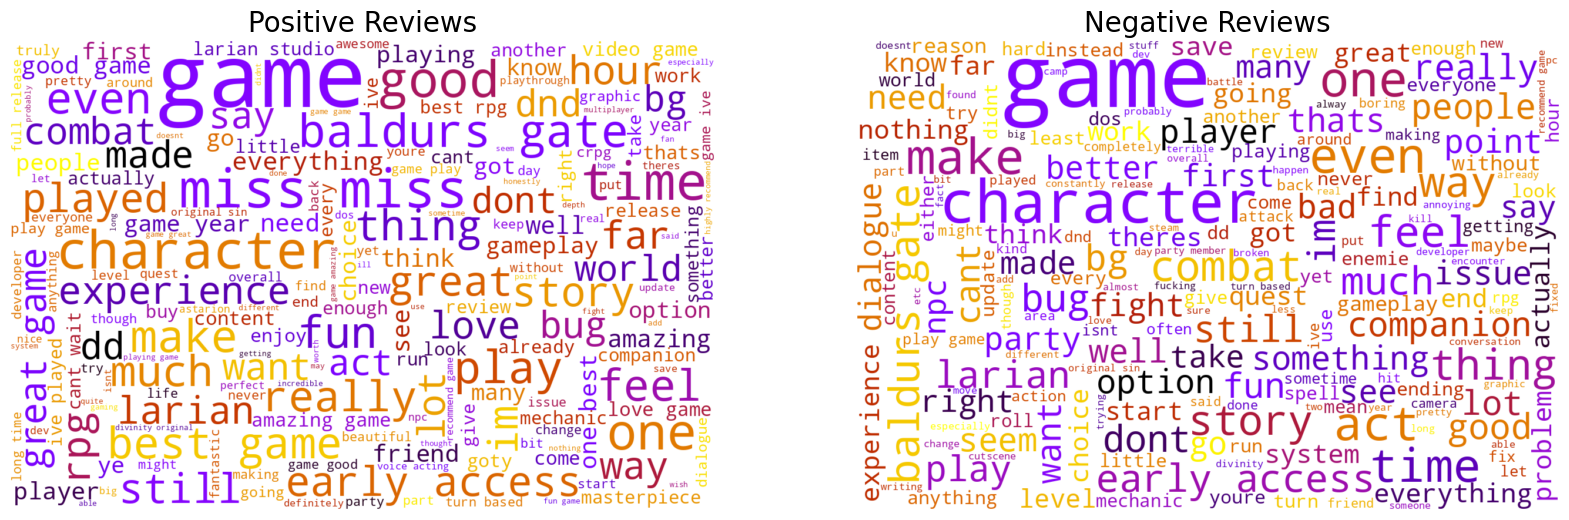

In [25]:
# Visualizing the negative and positive reviews using word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
words_pos = ' '.join([" ".join(review) for review in df[df['voted_up'] == 1]['without_stopwords']])
words_neg = ' '.join([" ".join(review) for review in df[df['voted_up'] == 0]['without_stopwords']])
wordcloud_pos = WordCloud(width = 1200, height = 800, random_state=42, max_font_size=150, background_color='#FFFFFF', colormap = 'gnuplot_r').generate(words_pos)
wordcloud_neg = WordCloud(width = 1200, height = 800, random_state=42, max_font_size=150, background_color='#FFFFFF', colormap = 'gnuplot_r').generate(words_neg)
ax1.imshow(wordcloud_pos, interpolation="bilinear")
ax1.axis('off')
ax1.set_title('Positive Reviews', fontsize=20)
ax2.imshow(wordcloud_neg, interpolation="bilinear")
ax2.axis('off')
ax2.set_title('Negative Reviews', fontsize=20)
plt.show()

## Splitting the Data into Training, Validation, and Testing Sets
### Utilizing `train_test_split` function to split the data into training and testing sets for the original reviews, reviews without stopwords and lemmatized reviews
- **ws**: Without stop words
- **lem**: With lemmatization

The shapes of the resulting sets are printed to ensure the splits are correct.

In [26]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['voted_up'], test_size=0.2, random_state=42)
X_train_ws, X_test_ws, y_train_ws, y_test_ws = train_test_split(df['without_stopwords'], df['voted_up'], test_size=0.2, random_state=42)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(df['lemmatized'], df['voted_up'], test_size=0.2, random_state=42)

# creating the valisation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train_ws, X_val_ws, y_train_ws, y_val_ws = train_test_split(X_train_ws, y_train_ws, test_size=0.1, random_state=42)
X_train_lem, X_val_lem, y_train_lem, y_val_lem = train_test_split(X_train_lem, y_train_lem, test_size=0.1, random_state=42)

# printing the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (14625,), (14625,)
Validation set shape: (1626,), (1626,)
Testing set shape: (4063,), (4063,)


### Inspecting Training Data Samples
The first 8 reviews and their corresponding sentiment labels from the training set are printed. This step ensures:
- The data is correctly split.
- The labels (`Sentiment`) align with the reviews (`Review`).

In [27]:
for i in range(8):
    print(f"Review: {X_train.iloc[i]} \nSentiment: {y_train.iloc[i]} \n")

Review: ['yet', 'another', 'notcomplete', 'game', 'at', 'release', 'even', 'though', 'i', 'meet', 'the', 'recommended', 'specs', 'the', 'game', 'runs', 'horribly', 'with', 'a', 'lot', 'of', 'stuttering', 'in', 'cs', 'if', 'i', 'want', 'to', 'run', 'smooth', 'i', 'have', 'to', 'majorly', 'dumb', 'down', 'the', 'settings', 'even', 'though', 'the', 'autodetect', 'says', 'i', 'can', 'run', 'on', 'ultra', 'i', 'spent', 'most', 'of', 'my', 'playtime', 'trying', 'to', 'get', 'the', 'game', 'to', 'work', 'i', 'ended', 'up', 'getting', 'it', 'for', 'the', 'ps', 'and', 'it', 'is', 'so', 'much', 'better', 'there', 'less', 'bugs', 'but', 'still', 'a', 'lot', 'some', 'that', 'lock', 'my', 'characters', 'in', 'place', 'and', 'i', 'have', 'to', 'load', 'a', 'save', 'game', 'from', 'hours', 'ago', 'i', 'like', 'the', 'story', 'so', 'far', 'but', 'i', 'am', 'not', 'liking', 'the', 'dice', 'mechanic', 'as', 'a', 'dm', 'i', 'get', 'what', 'it', 'is', 'trying', 'to', 'do', 'but', 'sometimes', 'the', 'roll

## **BoW**: Bag of Words Representation
### The `CountVectorizer` is used to convert the text data into a Bag of Words (BoW) representation.
- `min_df=1`: Includes words that appear in at least one document.
- `max_df=1.0`: Includes words that appear in up to 100% of the documents.
- `ngram_range=(1, 3)`: Considers unigrams, bigrams, and trigrams.

In [28]:
# Count vectorizer for bag of words
BoW = CountVectorizer(min_df=1, max_df=1.0, binary=False, ngram_range=(1, 3))

# Joining the tokens back into strings
X_train_str = X_train.apply(lambda x: ' '.join(x))
X_val_str = X_val.apply(lambda x: ' '.join(x))
X_test_str = X_test.apply(lambda x: ' '.join(x))

# Transforming the datasets
bow_X_train = BoW.fit_transform(X_train_str)
bow_X_val = BoW.transform(X_val_str)
bow_X_test = BoW.transform(X_test_str)

# Dimensions of the training, validation and test dataset after BOW conversion.
# The second dimension is the number of features extracted by BOW
print('BOW training matrix shape:',bow_X_train.shape)
print('BOW validation matrix shape:',bow_X_val.shape)
print('BOW test matrix shape:',bow_X_test.shape)

BOW training matrix shape: (14625, 1147934)
BOW validation matrix shape: (1626, 1147934)
BOW test matrix shape: (4063, 1147934)


#### The Bag of Words (BoW) representation is applied to the preprocessed reviews:

- Without Stopwords
- Lemmatized Reviews

In [29]:
# We do the same for the reviews without stopwords and lemmatized reviews
X_train_ws_str = X_train_ws.apply(lambda x: ' '.join(x))
X_val_ws_str = X_val_ws.apply(lambda x: ' '.join(x))
X_test_ws_str = X_test_ws.apply(lambda x: ' '.join(x))

bow_X_train_ws = BoW.fit_transform(X_train_ws_str)
bow_X_val_ws = BoW.transform(X_val_ws_str)
bow_X_test_ws = BoW.transform(X_test_ws_str)

print('BOW training matrix shape of data without stop words:',bow_X_train_ws.shape)
print('BOW validation matrix shape of data without stop words:',bow_X_val_ws.shape)
print('BOW test matrix shape of data without stop words:',bow_X_test_ws.shape)



X_train_lem_str = X_train_lem.apply(lambda x: ' '.join(x))
X_val_lem_str = X_val_lem.apply(lambda x: ' '.join(x))
X_test_lem_str = X_test_lem.apply(lambda x: ' '.join(x))

bow_X_train_lem = BoW.fit_transform(X_train_lem_str)
bow_X_val_lem = BoW.transform(X_val_lem_str)
bow_X_test_lem = BoW.transform(X_test_lem_str)

print('\n\nBOW training matrix shape of lemmatized data:',bow_X_train_lem.shape)
print('BOW validation matrix shape of lemmatized data:',bow_X_val_lem.shape)
print('BOW test matrix shape of lemmatized data:',bow_X_test_lem.shape)

BOW training matrix shape of data without stop words: (14625, 948218)
BOW validation matrix shape of data without stop words: (1626, 948218)
BOW test matrix shape of data without stop words: (4063, 948218)


BOW training matrix shape of lemmatized data: (14625, 920416)
BOW validation matrix shape of lemmatized data: (1626, 920416)
BOW test matrix shape of lemmatized data: (4063, 920416)


## **TF-IDF Vectorizer** Initialization

### The `TfidfVectorizer` is used to convert the text data into numerical using the TF-IDF model, and capture the importance of terms relative to each document and the entire corpus.

*Removing stopwords will reduce dimensionality and noise. This might improve the training process beacuse of we keep more meaningful features*

https://www.geeksforgeeks.org/visualizing-tf-idf-scores-a-comprehensive-guide-to-plotting-a-document-tf-idf-2d-graph/

TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents. It combines two metrics:
- Term Frequency (TF): The number of times a term appears in a document.
- Inverse Document Frequency (IDF): A measure of how much information the word provides, i.e., whether the term is common or rare across all documents.

In [30]:
#Tfidf vectorizer
TFIDF = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True, ngram_range=(1,3))

#transformed train reviews
tfidf_X_train = TFIDF.fit_transform(X_train_str)
#transformed validation reviews
tfidf_X_val = TFIDF.transform(X_val_str)
#transformed test reviews
tfidf_X_test = TFIDF.transform(X_test_str)

print('TF-IDF training matrix shape:',tfidf_X_train.shape)
print('TF-IDF validation matrix shape:',tfidf_X_val.shape)
print('TF-IDF test matrix shape:',tfidf_X_test.shape)

# We do the same for the reviews without stopwords and lemmatized reviews
tfidf_X_train_ws = TFIDF.fit_transform(X_train_ws_str)
tfidf_X_val_ws = TFIDF.transform(X_val_ws_str)
tfidf_X_test_ws = TFIDF.transform(X_test_ws_str)

print('\n\nTF-IDF training matrix shape of data without stop words:',tfidf_X_train_ws.shape)
print('TF-IDF validation matrix shape of data without stop words:',tfidf_X_val_ws.shape)
print('TF-IDF test matrix shape of data without stop words:',tfidf_X_test_ws.shape)

tfidf_X_train_lem = TFIDF.fit_transform(X_train_lem_str)
tfidf_X_val_lem = TFIDF.transform(X_val_lem_str)
tfidf_X_test_lem = TFIDF.transform(X_test_lem_str)

print('\n\nTF-IDF training matrix shape of lemmatized data:',tfidf_X_train_lem.shape)
print('TF-IDF validation matrix shape of lemmatized data:',tfidf_X_val_lem.shape)
print('TF-IDF test matrix shape of lemmatized data:',tfidf_X_test_lem.shape)

TF-IDF training matrix shape: (14625, 1147934)
TF-IDF validation matrix shape: (1626, 1147934)
TF-IDF test matrix shape: (4063, 1147934)


TF-IDF training matrix shape of data without stop words: (14625, 948218)
TF-IDF validation matrix shape of data without stop words: (1626, 948218)
TF-IDF test matrix shape of data without stop words: (4063, 948218)


TF-IDF training matrix shape of lemmatized data: (14625, 920416)
TF-IDF validation matrix shape of lemmatized data: (1626, 920416)
TF-IDF test matrix shape of lemmatized data: (4063, 920416)


# **Logistic Regression**
The LogisticRegression model is initialized. Logistic Regression is a simple yet effective machine learning algorithm used for binary classification tasks.

In [31]:
lr=LogisticRegression()

## **Training Logistic Regression**

### **Original Reviews**
#### The `LogisticRegression` model is trained using:
- **Bag of Words (BoW)** representation.
- **TF-IDF** representation.

Training time for each representation is measured using perf_counter() to evaluate computational efficiency.

In [103]:
# Training the model with the original reviews
lr_bow = LogisticRegression()
lr_tfidf = LogisticRegression()
start1 = perf_counter()
lr_bow.fit(bow_X_train, y_train)
end1 = perf_counter()
start2 = perf_counter()
lr_tfidf.fit(tfidf_X_train, y_train)
end2 = perf_counter()

print(f"Time taken to train LR model with BOW: {end1-start1:.2f} seconds")
print(f"Time taken to train LR model with TF-IDF: {end2-start2:.2f} seconds")

Time taken to train LR model with BOW: 8.97 seconds
Time taken to train LR model with TF-IDF: 2.39 seconds


### **Training Logistic Regression on Reviews Without Stopwords**

In [104]:
# Training the model with the data without stopwords
lr_bow_ws=LogisticRegression()
lr_tfidf_ws=LogisticRegression()
start3 = perf_counter()
lr_bow_ws.fit(bow_X_train_ws, y_train_ws)
end3 = perf_counter()
start4 = perf_counter()
lr_tfidf_ws.fit(tfidf_X_train_ws, y_train_ws)
end4 = perf_counter()

print(f"Time taken to train LR model with BOW without stopwords: {end3-start3:.2f} seconds")
print(f"Time taken to train LR model with TF-IDF without stopwords: {end4-start4:.2f} seconds")

Time taken to train LR model with BOW without stopwords: 5.37 seconds
Time taken to train LR model with TF-IDF without stopwords: 2.88 seconds


### **Training Logistic Regression on Lemmatized Reviews**

In [105]:
# Training the model with the lemmatized data
lr_bow_lem=LogisticRegression()
lr_tfidf_lem=LogisticRegression()
start5 = perf_counter()
lr_bow_lem.fit(bow_X_train_lem, y_train_lem)
end5 = perf_counter()
start6 = perf_counter()
lr_tfidf_lem.fit(tfidf_X_train_lem, y_train_lem)
end6 = perf_counter()

print(f"Time taken to train LR model with BOW lemmatized data: {end5-start5:.2f} seconds")
print(f"Time taken to train LR model with TF-IDF lemmatized data: {end6-start6:.2f} seconds")

Time taken to train LR model with BOW lemmatized data: 5.43 seconds
Time taken to train LR model with TF-IDF lemmatized data: 2.61 seconds


## **Cross-Validation on Validation Set**
Cross-validation is performed on the validation set to evaluate the performance of the Logistic Regression models and detect overfitting.

In [35]:
# Doing cross-validation on the validation set to check for overfitting
cv_bow = cross_val_score(lr_bow, bow_X_val, y_val, cv=5)
cv_tfidf = cross_val_score(lr_tfidf, tfidf_X_val, y_val, cv=5)

print(f"Cross-validation mean score for BoW in the original data:      {cv_bow.mean()}")
print(f"Cross-validation mean score for TF-IDF in the original data:   {cv_tfidf.mean()}")

Cross-validation mean score for BoW in the original data:      0.8450174610665409
Cross-validation mean score for TF-IDF in the original data:   0.8259613025011798


In [36]:
# Doing cross-validation on the validation set without stopwords to check for overfitting
cv_bow_ws = cross_val_score(lr_bow_ws, bow_X_val_ws, y_val_ws, cv=5)
cv_tfidf_ws = cross_val_score(lr_tfidf_ws, tfidf_X_val_ws, y_val_ws, cv=5)

print(f"Cross-validation mean score for BoW in the data without stopwords:      {cv_bow_ws.mean()}")
print(f"Cross-validation mean score for TF-IDF in the data without stopwords:   {cv_tfidf_ws.mean()}")

Cross-validation mean score for BoW in the data without stopwords:      0.8511543180745635
Cross-validation mean score for TF-IDF in the data without stopwords:   0.8573138272770174


In [37]:
# Doing cross-validation on the lemmatized validation set to check for overfitting
cv_bow_lem = cross_val_score(lr_bow_lem, bow_X_val_lem, y_val_lem, cv=5)
cv_tfidf_lem = cross_val_score(lr_tfidf_lem, tfidf_X_val_lem, y_val_lem, cv=5)

print(f"Cross-validation mean score for BoW in the lemmatized data:      {cv_bow_lem.mean()}")
print(f"Cross-validation mean score for TF-IDF in the lemmatized data:   {cv_tfidf_lem.mean()}")

Cross-validation mean score for BoW in the lemmatized data:      0.8474601226993865
Cross-validation mean score for TF-IDF in the lemmatized data:   0.861004247286456


## **Making Predictions with Logistic Regression Models**
### Using the trained Logistic Regression models, predictions are made on the test sets

In [38]:
# Predicting with the Bag of Words model from the original data
lr_bow_predict=lr_bow.predict(bow_X_test)
# Predicting with the TF-IDF model from the original data
lr_tfidf_predict=lr_tfidf.predict(tfidf_X_test)

In [39]:
# Predicting with the Bag of Words model from the data without stopwords
lr_bow_ws_predict=lr_bow_ws.predict(bow_X_test_ws)
# Predicting with the TF-IDF model from the data without stopwords
lr_tfidf_ws_predict=lr_tfidf_ws.predict(tfidf_X_test_ws)

In [40]:
# Predicting with the Bag of Words model from the lemmatized data
lr_bow_lem_predict=lr_bow_lem.predict(bow_X_test_lem)
# Predicting with the TF-IDF model from the lemmatized data
lr_tfidf_lem_predict=lr_tfidf_lem.predict(tfidf_X_test_lem)

## **Evaluation of Logistic Regression Models**

### Accuracy Score
In this code cell we will compute the proportion of the correct predictions made by the `BoW` & `TF-IDF` models compared to the actual labels, and then display the accuracy score. The accuracy score is useful for balanced datasets but if it is imbalanced, we should consider using a classification report which will present the precision, recall and f1-score of the predictions.

In [41]:
# Accuracy score of the Bag of Words model from the original data
lr_bow_score=accuracy_score(y_test, lr_bow_predict)
# Accuracy score of the TF-IDF model from the original data
lr_tfidf_score=accuracy_score(y_test, lr_tfidf_predict)
# Printing the accuracy scores
print(f"Accuracy score of the BoW model from the original data:      {lr_bow_score}")
print(f"Accuracy score of the TF-IDF model from the original data:   {lr_tfidf_score}")

Accuracy score of the BoW model from the original data:      0.8939207482156042
Accuracy score of the TF-IDF model from the original data:   0.8821068176224465


In [42]:
# Accuracy score of the Bag of Words model from the data without stopwords
lr_bow_ws_score=accuracy_score(y_test_ws, lr_bow_ws_predict)
# Accuracy score of the TF-IDF model from the data without stopwords
lr_tfidf_ws_score=accuracy_score(y_test_ws, lr_tfidf_ws_predict)
# Printing the accuracy scores
print(f"Accuracy score of the BoW model from the data without stopwords:      {lr_bow_ws_score}")
print(f"Accuracy score of the TF-IDF model from the data without stopwords:   {lr_tfidf_ws_score}")

Accuracy score of the BoW model from the data without stopwords:      0.8867831651489048
Accuracy score of the TF-IDF model from the data without stopwords:   0.8818606940684224


In [43]:
# Accuracy score of the Bag of Words model from the lemmatized data
lr_bow_lem_score=accuracy_score(y_test_lem, lr_bow_lem_predict)
# Accuracy score of the TF-IDF model from the lemmatized data
lr_tfidf_lem_score=accuracy_score(y_test_lem, lr_tfidf_lem_predict)
# Printing the accuracy scores
print(f"Accuracy score of the BoW model from the lemmatized data:      {lr_bow_lem_score}")
print(f"Accuracy score of the TF-IDF model from the lemmatized data:   {lr_tfidf_lem_score}")

Accuracy score of the BoW model from the lemmatized data:      0.8857986709328083
Accuracy score of the TF-IDF model from the lemmatized data:   0.8818606940684224


### Classification Report
By analyzing these metrics, we can determine which feature extraction method `BoW` or `TF-IDF`, yields better performance for our sentiment classification task and we will determine if normalizing the data proves usefull

In [99]:
# Classification report of the Bag of Words model from the original data
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Negative','Positive'])
# Classification report of the TF-IDF model from the original data
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Negative','Positive'])
print(f"LogReg Classification Report of the Bag of Words Model from the original data: \n{lr_bow_report} \n\nLogReg Classification Report of the TF-IDF Model from the original data: \n{lr_tfidf_report}")

LogReg Classification Report of the Bag of Words Model from the original data: 
              precision    recall  f1-score   support

    Negative       0.92      0.86      0.89      2023
    Positive       0.87      0.93      0.90      2040

    accuracy                           0.89      4063
   macro avg       0.90      0.89      0.89      4063
weighted avg       0.90      0.89      0.89      4063
 

LogReg Classification Report of the TF-IDF Model from the original data: 
              precision    recall  f1-score   support

    Negative       0.86      0.91      0.89      2023
    Positive       0.91      0.85      0.88      2040

    accuracy                           0.88      4063
   macro avg       0.88      0.88      0.88      4063
weighted avg       0.88      0.88      0.88      4063



In [45]:
# Classification report of the Bag of Words model from the data without stopwords
lr_bow_ws_report=classification_report(y_test_ws,lr_bow_ws_predict,target_names=['Negative','Positive'])
# Classification report of the TF-IDF model from the data without stopwords
lr_tfidf_ws_report=classification_report(y_test_ws,lr_tfidf_ws_predict,target_names=['Negative','Positive'])
print(f"LogReg Classification Report of the Bag of Words Model from the data without stopwords: \n{lr_bow_ws_report} \n\nLogReg Classification Report of the TF-IDF Model from the data without stopwords: \n{lr_tfidf_ws_report}")

LogReg Classification Report of the Bag of Words Model from the data without stopwords: 
              precision    recall  f1-score   support

    Negative       0.92      0.85      0.88      2023
    Positive       0.86      0.92      0.89      2040

    accuracy                           0.89      4063
   macro avg       0.89      0.89      0.89      4063
weighted avg       0.89      0.89      0.89      4063
 

LogReg Classification Report of the TF-IDF Model from the data without stopwords: 
              precision    recall  f1-score   support

    Negative       0.85      0.92      0.89      2023
    Positive       0.91      0.84      0.88      2040

    accuracy                           0.88      4063
   macro avg       0.88      0.88      0.88      4063
weighted avg       0.88      0.88      0.88      4063



In [46]:
# Classification report of the Bag of Words model from the lemmatized data
lr_bow_lem_report=classification_report(y_test_lem,lr_bow_lem_predict,target_names=['Negative','Positive'])
# Classification report of the TF-IDF model from the lemmatized data
lr_tfidf_lem_report=classification_report(y_test_lem,lr_tfidf_lem_predict,target_names=['Negative','Positive'])
print(f"LogReg Classification Report of the Bag of Words Model from the lemmatized data: \n{lr_bow_lem_report} \n\nLogReg Classification Report of the TF-IDF Model from the lemmatized data: \n{lr_tfidf_lem_report}")

LogReg Classification Report of the Bag of Words Model from the lemmatized data: 
              precision    recall  f1-score   support

    Negative       0.91      0.85      0.88      2023
    Positive       0.86      0.92      0.89      2040

    accuracy                           0.89      4063
   macro avg       0.89      0.89      0.89      4063
weighted avg       0.89      0.89      0.89      4063
 

LogReg Classification Report of the TF-IDF Model from the lemmatized data: 
              precision    recall  f1-score   support

    Negative       0.85      0.92      0.89      2023
    Positive       0.92      0.84      0.88      2040

    accuracy                           0.88      4063
   macro avg       0.88      0.88      0.88      4063
weighted avg       0.88      0.88      0.88      4063



### Confusion Matrix
Visualizing the confusion matrices side by side allows for a direct comparison of the performance between the two models. By normalizing the matrices and displaying them as heatmaps, it's easier to interpret the proportion of correct and incorrect predictions for each class

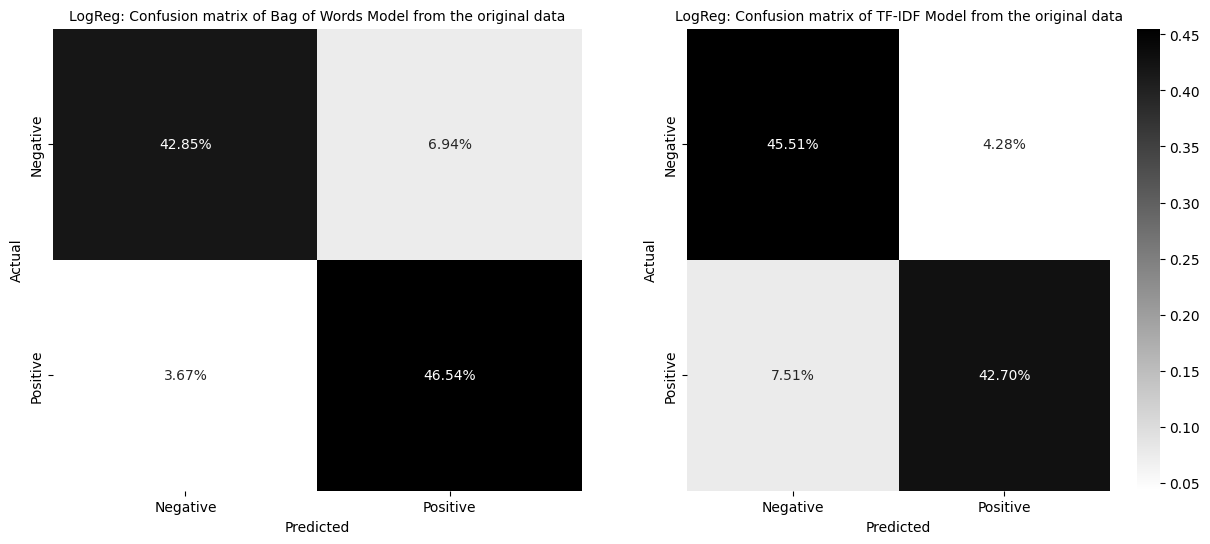

In [47]:
# Confusion matrix for original data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow=confusion_matrix(y_test,lr_bow_predict)
# create heatmap
sns.heatmap(cm_bow/np.sum(cm_bow), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('LogReg: Confusion matrix of Bag of Words Model from the original data', fontsize=10)

cm_tfidf=confusion_matrix(y_test,lr_tfidf_predict)
sns.heatmap(cm_tfidf/np.sum(cm_tfidf), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('LogReg: Confusion matrix of TF-IDF Model from the original data', fontsize=10)

plt.show()

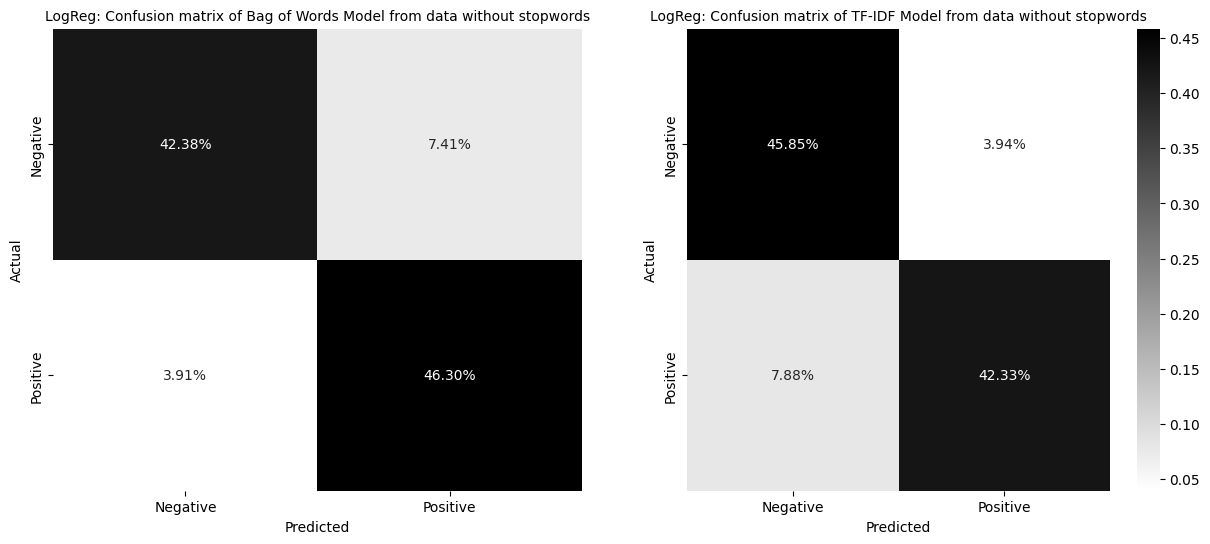

In [100]:
# Confusiuon matrix for data without stopwords
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow_ws=confusion_matrix(y_test_ws,lr_bow_ws_predict)
# create heatmap
sns.heatmap(cm_bow_ws/np.sum(cm_bow_ws), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('LogReg: Confusion matrix of Bag of Words Model from data without stopwords', fontsize=10)

cm_tfidf_ws=confusion_matrix(y_test_ws,lr_tfidf_ws_predict)
sns.heatmap(cm_tfidf_ws/np.sum(cm_tfidf_ws), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('LogReg: Confusion matrix of TF-IDF Model from data without stopwords', fontsize=10)

plt.show()

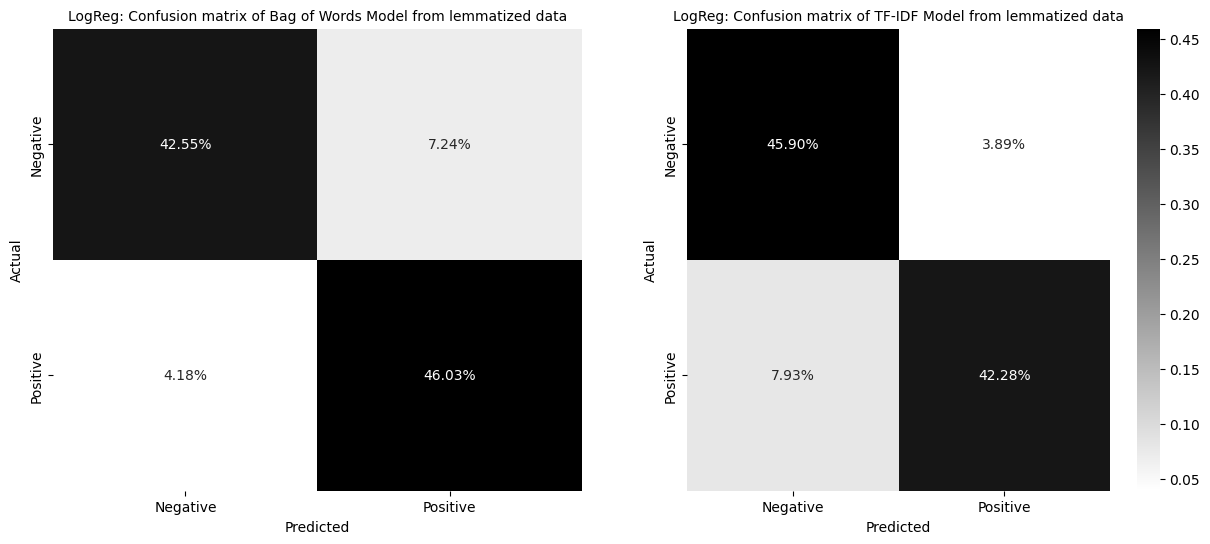

In [49]:
# Confusiuon matrix for lemmatized data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow_lem=confusion_matrix(y_test_lem,lr_bow_lem_predict)
# create heatmap
sns.heatmap(cm_bow_lem/np.sum(cm_bow_lem), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('LogReg: Confusion matrix of Bag of Words Model from lemmatized data', fontsize=10)

cm_tfidf_lem=confusion_matrix(y_test_lem,lr_tfidf_lem_predict)
sns.heatmap(cm_tfidf_lem/np.sum(cm_tfidf_lem), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('LogReg: Confusion matrix of TF-IDF Model from lemmatized data', fontsize=10)

plt.show()

## **ROC Curves** https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
- ### This code computes the Area Under the Curve (AUC) for the logistic regression models and displays the Receiver Operating Characteristic (ROC) curves.
- ### ROC curves illustrate the models' behavior across different classification thresholds, helping in threshold optimization.
    - A higher AUC value indicates better model performance in distinguishing between classes. 

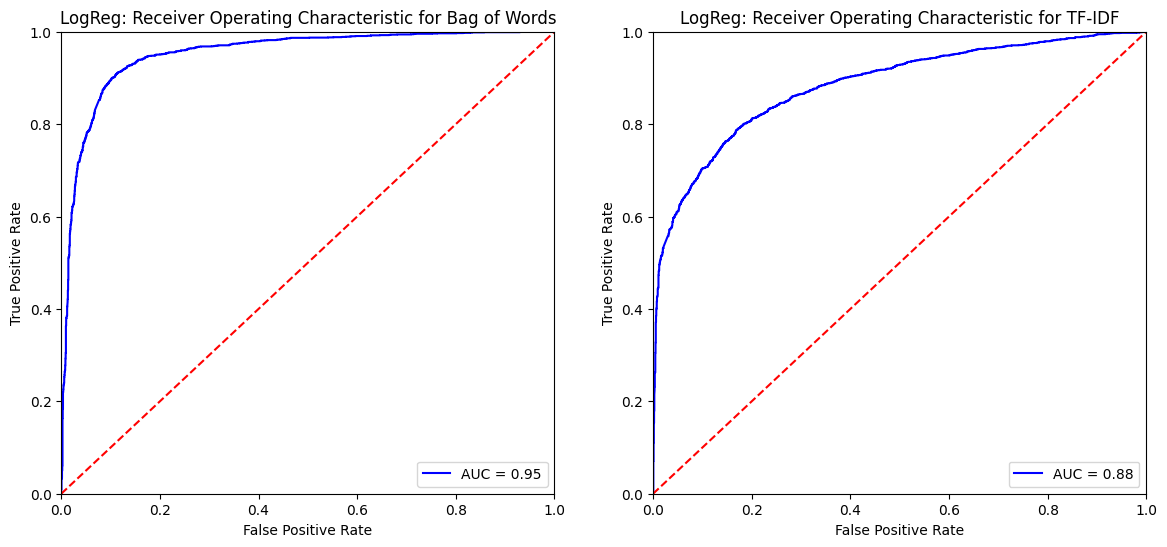

In [98]:
#ROC-AUC curve of bag of words model from the original data
probs_bow = lr_bow.predict_proba(bow_X_test)
preds_bow = probs_bow[:,1]
fpr_lr_bow, trp_lr_bow, thresholds_lr_bow = roc_curve(y_test, preds_bow)
roc_auc_lr_bow = auc(fpr_lr_bow, trp_lr_bow)
#ROC-AUC curve for tfidf features
probs_tfidf = lr_tfidf.predict_proba(bow_X_test)
preds_tfidf = probs_tfidf[:,1]
fpr_lr_tfidf, trp_lr_tfidf, thresholds_lr_tfidf = roc_curve(y_test, preds_tfidf)
roc_auc_lr_tfidf = auc(fpr_lr_tfidf, trp_lr_tfidf)

#Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('LogReg: Receiver Operating Characteristic for Bag of Words')
plt.plot(fpr_lr_bow, trp_lr_bow, 'b', label = 'AUC = %0.2f' % roc_auc_lr_bow)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('LogReg: Receiver Operating Characteristic for TF-IDF')
plt.plot(fpr_lr_tfidf, trp_lr_tfidf, 'b', label = 'AUC = %0.2f' % roc_auc_lr_tfidf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

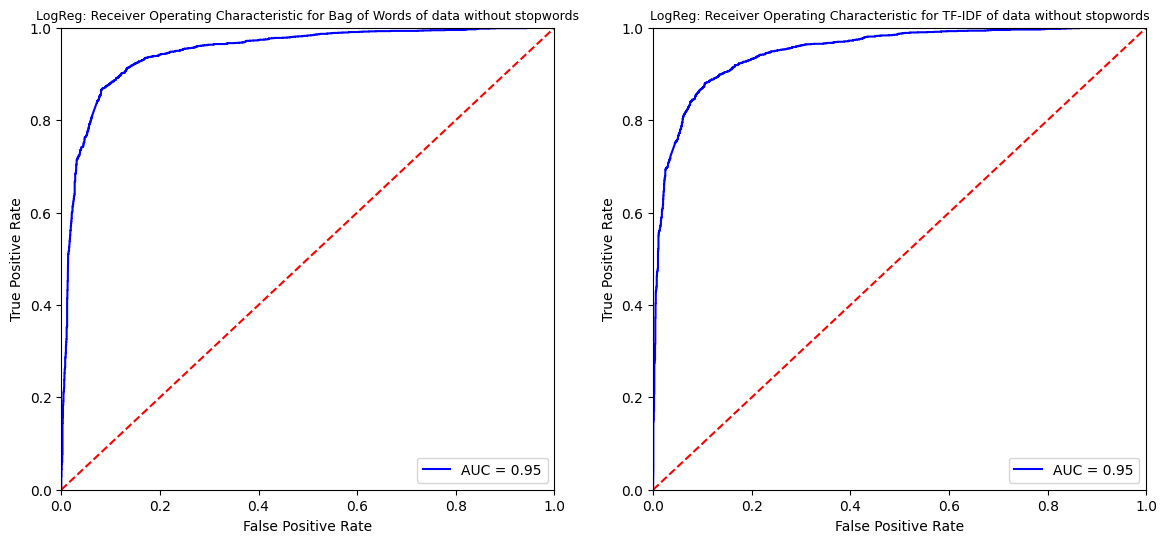

In [51]:
#ROC-AUC curve of bag of words model from the data without stopwords
probs_bow_ws = lr_bow_ws.predict_proba(bow_X_test_ws)
preds_bow_ws = probs_bow_ws[:,1]
fpr_lr_bow_ws, trp_lr_bow_ws, thresholds_lr_bow_ws = roc_curve(y_test_ws, preds_bow_ws)
roc_auc_lr_bow_ws = auc(fpr_lr_bow_ws, trp_lr_bow_ws)
#ROC-AUC curve for tfidf features
probs_tfidf_ws = lr_tfidf_ws.predict_proba(tfidf_X_test_ws)
preds_tfidf_ws = probs_tfidf_ws[:,1]
fpr_lr_tfidf_ws, trp_lr_tfidf_ws, thresholds_lr_tfidf_ws = roc_curve(y_test_ws, preds_tfidf_ws)
roc_auc_lr_tfidf_ws = auc(fpr_lr_tfidf_ws, trp_lr_tfidf_ws)

#Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('LogReg: Receiver Operating Characteristic for Bag of Words of data without stopwords', fontsize=9)
plt.plot(fpr_lr_bow_ws, trp_lr_bow_ws, 'b', label = 'AUC = %0.2f' % roc_auc_lr_bow_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('LogReg: Receiver Operating Characteristic for TF-IDF of data without stopwords', fontsize=9)
plt.plot(fpr_lr_tfidf_ws, trp_lr_tfidf_ws, 'b', label = 'AUC = %0.2f' % roc_auc_lr_tfidf_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

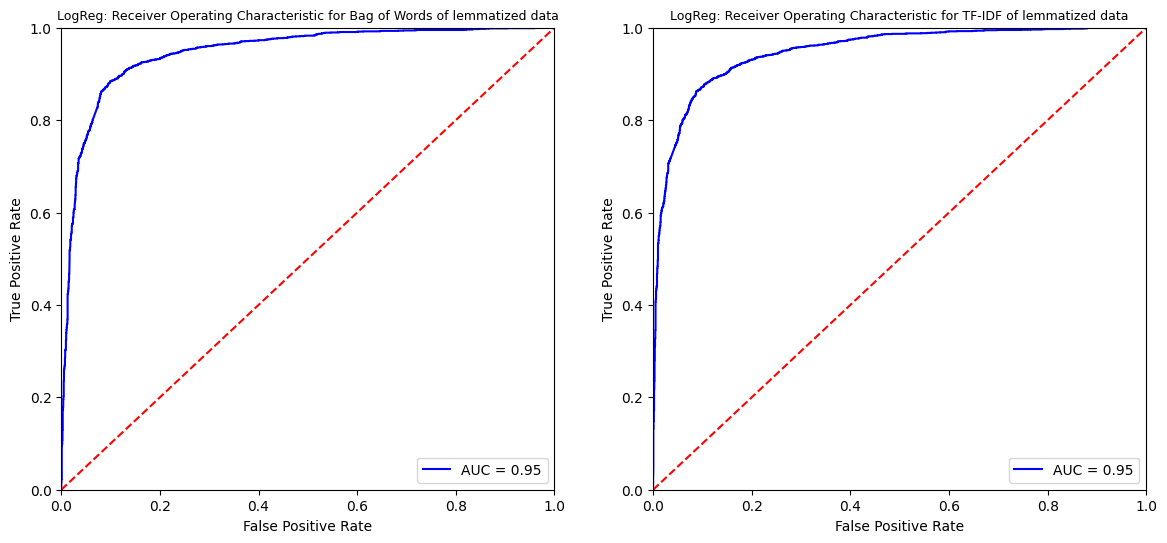

In [52]:
# ROC-AUC curve of bag of words model from the lemmatized data
probs_bow_lem = lr_bow_lem.predict_proba(bow_X_test_lem)
preds_bow_lem = probs_bow_lem[:,1]
fpr_lr_bow_lem, trp_lr_bow_lem, thresholds_lr_bow_lem = roc_curve(y_test_lem, preds_bow_lem)
roc_auc_lr_bow_lem = auc(fpr_lr_bow_lem, trp_lr_bow_lem)
# ROC-AUC curve for tfidf features
probs_tfidf_lem = lr_tfidf_lem.predict_proba(tfidf_X_test_lem)
preds_tfidf_lem = probs_tfidf_lem[:,1]
fpr_lr_tfidf_lem, trp_lr_tfidf_lem, thresholds_lr_tfidf_lem = roc_curve(y_test_lem, preds_tfidf_lem)
roc_auc_lr_tfidf_lem = auc(fpr_lr_tfidf_lem, trp_lr_tfidf_lem)

# Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('LogReg: Receiver Operating Characteristic for Bag of Words of lemmatized data', fontsize=9)
plt.plot(fpr_lr_bow_lem, trp_lr_bow_lem, 'b', label = 'AUC = %0.2f' % roc_auc_lr_bow_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('LogReg: Receiver Operating Characteristic for TF-IDF of lemmatized data', fontsize=9)
plt.plot(fpr_lr_tfidf_lem, trp_lr_tfidf_lem, 'b', label = 'AUC = %0.2f' % roc_auc_lr_tfidf_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Stohastic Gradient Descent Model** 

https://stackoverflow.com/questions/29704231/in-sklearn-what-is-the-difference-between-a-svm-model-with-linear-kernel-and-a-s

https://scikit-learn.org/stable/modules/sgd.html

## **Training SVM Models**
The `SGDClassifier`, a linear SVM model.

We apply the same training procedure with the Logistic Regression

In [106]:
svm_bow = SGDClassifier()
svm_tfidf = SGDClassifier()
start7 = perf_counter()
svm_bow.fit(bow_X_train, y_train)
end7 = perf_counter()
start8 = perf_counter()
svm_tfidf.fit(tfidf_X_train, y_train)
end8 = perf_counter()

print(f"Time taken to train SVM model with BOW: {end7-start7:.2f} seconds")
print(f"Time taken to train SVM model with TF-IDF: {end8-start8:.2f} seconds")

Time taken to train SVM model with BOW: 0.31 seconds
Time taken to train SVM model with TF-IDF: 0.12 seconds


In [108]:
# Data without stopwords
svm_bow_ws = SGDClassifier()
start9 = perf_counter()
svm_bow_ws.fit(bow_X_train_ws, y_train_ws)
end9 = perf_counter()
svm_tfidf_ws = SGDClassifier()
start10 = perf_counter()
svm_tfidf_ws.fit(tfidf_X_train_ws, y_train_ws)
end10 = perf_counter()

print(f"Time taken to train SVM model with BOW without stopwords: {end9-start9:.2f} seconds")
print(f"Time taken to train SVM model with TF-IDF without stopwords: {end10-start10:.2f} seconds")

Time taken to train SVM model with BOW without stopwords: 0.11 seconds
Time taken to train SVM model with TF-IDF without stopwords: 0.09 seconds


In [109]:
# Lemmatized data
svm_bow_lem = SGDClassifier()
start11 = perf_counter()
svm_bow_lem.fit(bow_X_train_lem, y_train_lem)
end11 = perf_counter()
svm_tfidf_lem = SGDClassifier()
start12 = perf_counter()
svm_tfidf_lem.fit(tfidf_X_train_lem, y_train_lem)
end12 = perf_counter()

print(f"Time taken to train SVM model with BOW lemmatized data: {end11-start11:.2f} seconds")
print(f"Time taken to train SVM model with TF-IDF lemmatized data: {end12-start12:.2f} seconds")

Time taken to train SVM model with BOW lemmatized data: 0.12 seconds
Time taken to train SVM model with TF-IDF lemmatized data: 0.08 seconds


## **Validation**

In [56]:
# Validating for original data
cv_bow_svm = cross_val_score(svm_bow, bow_X_val, y_val, cv=5)
cv_tfidf_svm = cross_val_score(svm_tfidf, tfidf_X_val, y_val, cv=5)

print(f"Cross-validation mean score for BoW in the original data:      {cv_bow_svm.mean()}")
print(f"Cross-validation mean score for TF-IDF in the original data:   {cv_tfidf_svm.mean()}")

Cross-validation mean score for BoW in the original data:      0.8326965549787635
Cross-validation mean score for TF-IDF in the original data:   0.8604020764511562


In [57]:
# Validating for data without stopwords
cv_bow_svm_ws = cross_val_score(svm_bow_ws, bow_X_val_ws, y_val_ws, cv=5)
cv_tfidf_svm_ws = cross_val_score(svm_tfidf_ws, tfidf_X_val_ws, y_val_ws, cv=5)

print(f"Cross-validation mean score for BoW in the data without stopwords:      {cv_bow_svm_ws.mean()}")
print(f"Cross-validation mean score for TF-IDF in the data without stopwords:   {cv_tfidf_svm_ws.mean()}")

Cross-validation mean score for BoW in the data without stopwords:      0.8364115148655026
Cross-validation mean score for TF-IDF in the data without stopwords:   0.8628504011326097


In [58]:
# Validating for lemmatized data
cv_bow_svm_lem = cross_val_score(svm_bow_lem, bow_X_val_lem, y_val_lem, cv=5)
cv_tfidf_svm_lem = cross_val_score(svm_tfidf_lem, tfidf_X_val_lem, y_val_lem, cv=5)

print(f"Cross-validation mean score for BoW in the lemmatized data:      {cv_bow_svm_lem.mean()}")
print(f"Cross-validation mean score for TF-IDF in the lemmatized data:   {cv_tfidf_svm_lem.mean()}")

Cross-validation mean score for BoW in the lemmatized data:      0.843171307220387
Cross-validation mean score for TF-IDF in the lemmatized data:   0.8659273242095328


## **Evaluation**

In [59]:
#Predicting with the Bag of Words model from the original data
svm_bow_predict=svm_bow.predict(bow_X_test)
#Predicting with the TF-IDF model from the original data
svm_tfidf_predict=svm_tfidf.predict(tfidf_X_test)

In [60]:
# Predicting with the Bag of Words model from the data without stopwords
svm_bow_ws_predict=svm_bow_ws.predict(bow_X_test_ws)
# Predicting with the TF-IDF model from the data without stopwords
svm_tfidf_ws_predict=svm_tfidf_ws.predict(tfidf_X_test_ws)

In [61]:
# Predicting with the Bag of Words model from the lemmatized data
svm_bow_lem_predict=svm_bow_lem.predict(bow_X_test_lem)
# Predicting with the TF-IDF model from the lemmatized data
svm_tfidf_lem_predict=svm_tfidf_lem.predict(tfidf_X_test_lem)

### Accuracy

In [62]:
#Accuracy score for bag of words model from the original data
svm_bow_score=accuracy_score(y_test, svm_bow_predict)
#Accuracy score for tfidf model from the original data
svm_tfidf_score=accuracy_score(y_test, svm_tfidf_predict)
#Printing the accuracy scores
print(f"Accuracy score of the BoW model from the original data:      {svm_bow_score}")
print(f"Accuracy score of the TF-IDF model from the original data:   {svm_tfidf_score}")

Accuracy score of the BoW model from the original data:      0.8936746246615801
Accuracy score of the TF-IDF model from the original data:   0.9047501845926655


In [63]:
# Accuracy score for bag of words model from the data without stopwords
svm_bow_ws_score=accuracy_score(y_test_ws, svm_bow_ws_predict)
# Accuracy score for tfidf model from the data without stopwords
svm_tfidf_ws_score=accuracy_score(y_test_ws, svm_tfidf_ws_predict)
# Printing the accuracy scores
print(f"Accuracy score of the BoW model from the data without stopwords:      {svm_bow_ws_score}")
print(f"Accuracy score of the TF-IDF model from the data without stopwords:   {svm_tfidf_ws_score}")

Accuracy score of the BoW model from the data without stopwords:      0.8926901304454836
Accuracy score of the TF-IDF model from the data without stopwords:   0.8985970957420625


In [64]:
# Accuracy score for bag of words model from the lemmatized data
svm_bow_lem_score=accuracy_score(y_test_lem, svm_bow_lem_predict)
# Accuracy score for tfidf model from the lemmatized data
svm_tfidf_lem_score=accuracy_score(y_test_lem, svm_tfidf_lem_predict)
# Printing the accuracy scores
print(f"Accuracy score of the BoW model from the lemmatized data:      {svm_bow_lem_score}")
print(f"Accuracy score of the TF-IDF model from the lemmatized data:   {svm_tfidf_lem_score}")

Accuracy score of the BoW model from the lemmatized data:      0.891213389121339
Accuracy score of the TF-IDF model from the lemmatized data:   0.8963819837558454


### Classification Report

In [65]:
# Classification report of the Bag of Words model from the original data
svm_bow_report=classification_report(y_test,svm_bow_predict,target_names=['Negative','Positive'])
# Classification report of the TF-IDF model from the original data
svm_tfidf_report=classification_report(y_test,svm_tfidf_predict,target_names=['Negative','Positive'])
print(f"SVM Classification Report of the Bag of Words Model from the original data: \n{svm_bow_report} \n\nSVM Classification Report of the TF-IDF Model from the original data: \n{svm_tfidf_report}")

SVM Classification Report of the Bag of Words Model from the original data: 
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      2023
    Positive       0.89      0.90      0.90      2040

    accuracy                           0.89      4063
   macro avg       0.89      0.89      0.89      4063
weighted avg       0.89      0.89      0.89      4063
 

SVM Classification Report of the TF-IDF Model from the original data: 
              precision    recall  f1-score   support

    Negative       0.89      0.92      0.91      2023
    Positive       0.92      0.89      0.90      2040

    accuracy                           0.90      4063
   macro avg       0.91      0.90      0.90      4063
weighted avg       0.91      0.90      0.90      4063



In [66]:
# Classification report of the Bag of Words model from the data without stopwords
svm_bow_ws_report=classification_report(y_test_ws,svm_bow_ws_predict,target_names=['Negative','Positive'])
# Classification report of the TF-IDF model from the data without stopwords
svm_tfidf_ws_report=classification_report(y_test_ws,svm_tfidf_ws_predict,target_names=['Negative','Positive'])
print(f"SVM Classification Report of the Bag of Words Model from the data without stopwords: \n{svm_bow_ws_report} \n\nSVM Classification Report of the TF-IDF Model from the data without stopwords: \n{svm_tfidf_ws_report}")

SVM Classification Report of the Bag of Words Model from the data without stopwords: 
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      2023
    Positive       0.88      0.91      0.89      2040

    accuracy                           0.89      4063
   macro avg       0.89      0.89      0.89      4063
weighted avg       0.89      0.89      0.89      4063
 

SVM Classification Report of the TF-IDF Model from the data without stopwords: 
              precision    recall  f1-score   support

    Negative       0.88      0.93      0.90      2023
    Positive       0.92      0.87      0.90      2040

    accuracy                           0.90      4063
   macro avg       0.90      0.90      0.90      4063
weighted avg       0.90      0.90      0.90      4063



In [67]:
# Classification report of the Bag of Words model from the lemmatized data
svm_bow_lem_report=classification_report(y_test_lem,svm_bow_lem_predict,target_names=['Negative','Positive'])
# Classification report of the TF-IDF model from the lemmatized data
svm_tfidf_lem_report=classification_report(y_test_lem,svm_tfidf_lem_predict,target_names=['Negative','Positive'])
print(f"SVM Classification Report of the Bag of Words Model from the lemmatized data: \n{svm_bow_lem_report} \n\nSVM Classification Report of the TF-IDF Model from the lemmatized data: \n{svm_tfidf_lem_report}")

SVM Classification Report of the Bag of Words Model from the lemmatized data: 
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89      2023
    Positive       0.89      0.90      0.89      2040

    accuracy                           0.89      4063
   macro avg       0.89      0.89      0.89      4063
weighted avg       0.89      0.89      0.89      4063
 

SVM Classification Report of the TF-IDF Model from the lemmatized data: 
              precision    recall  f1-score   support

    Negative       0.87      0.93      0.90      2023
    Positive       0.92      0.87      0.89      2040

    accuracy                           0.90      4063
   macro avg       0.90      0.90      0.90      4063
weighted avg       0.90      0.90      0.90      4063



### Confusion Matrix

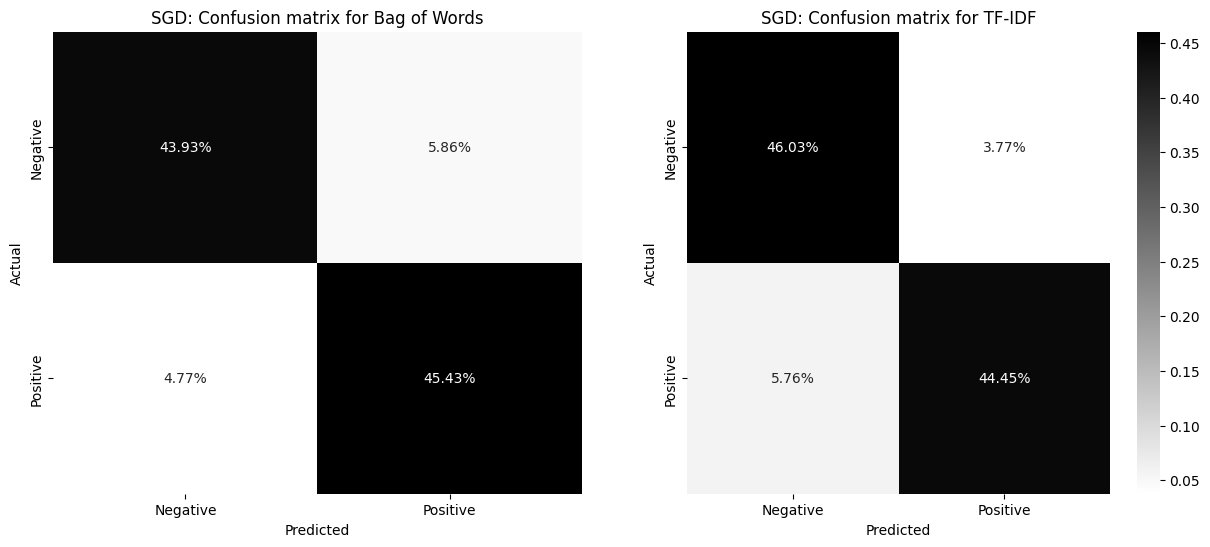

In [68]:
# For the original data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm2_bow=confusion_matrix(y_test, svm_bow_predict)
# create heatmap
sns.heatmap(cm2_bow/np.sum(cm2_bow), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('SGD: Confusion matrix for Bag of Words')

cm2_tfidf=confusion_matrix(y_test, svm_tfidf_predict)
sns.heatmap(cm2_tfidf/np.sum(cm2_tfidf), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('SGD: Confusion matrix for TF-IDF')

plt.show()

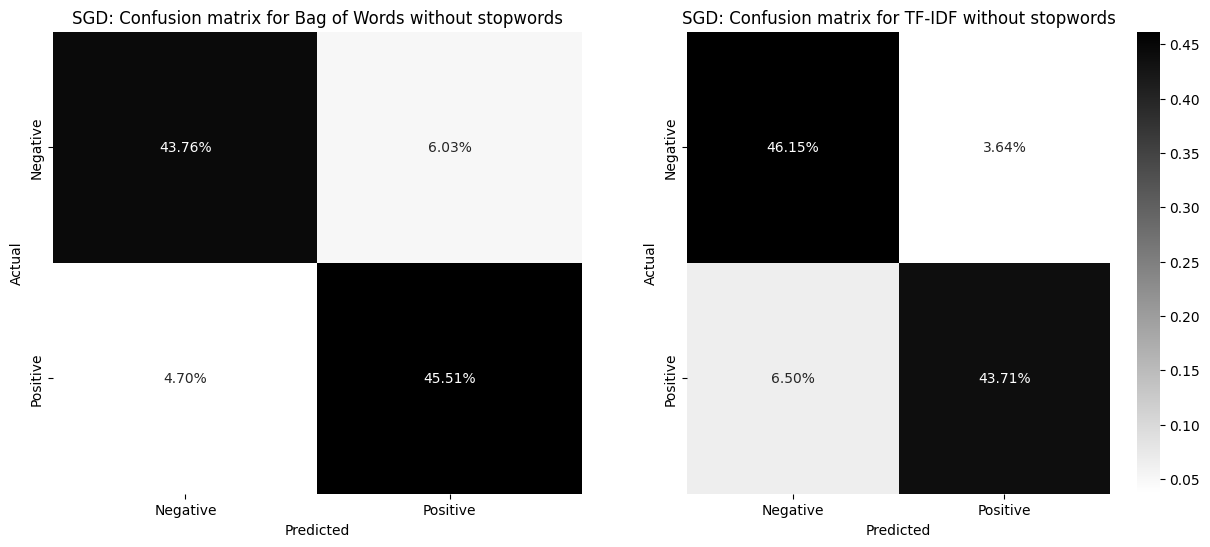

In [70]:
# For the data without stopwords
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm2_bow_ws=confusion_matrix(y_test_ws, svm_bow_ws_predict)
# create heatmap
sns.heatmap(cm2_bow_ws/np.sum(cm2_bow_ws), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('SGD: Confusion matrix for Bag of Words without stopwords')

cm2_tfidf_ws=confusion_matrix(y_test_ws, svm_tfidf_ws_predict)
sns.heatmap(cm2_tfidf_ws/np.sum(cm2_tfidf_ws), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('SGD: Confusion matrix for TF-IDF without stopwords')

plt.show()

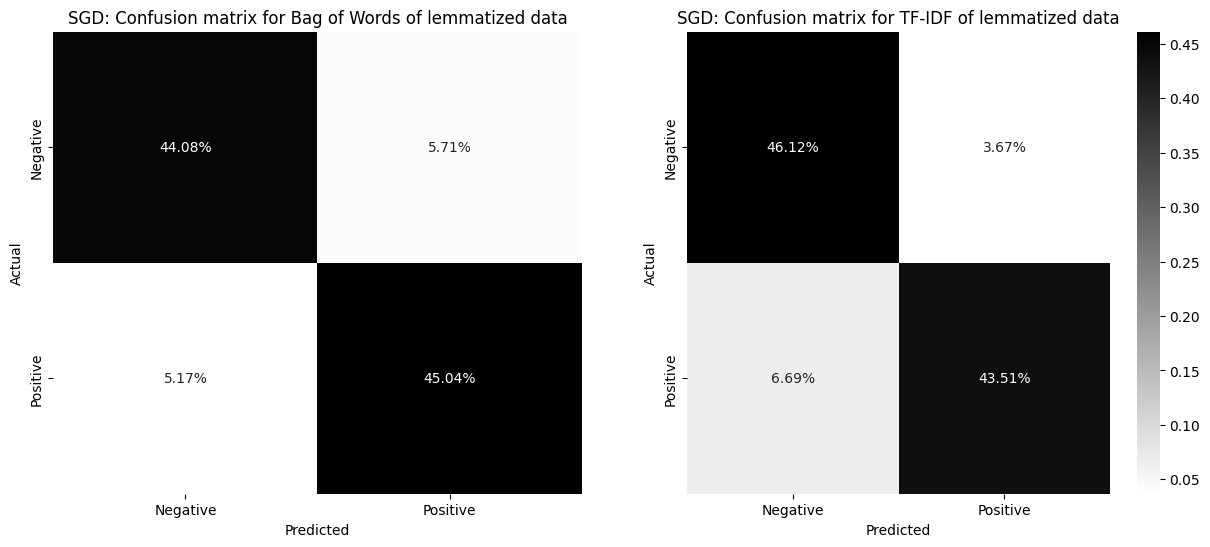

In [71]:
# For the lemmatized data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm2_bow_lem=confusion_matrix(y_test_lem, svm_bow_lem_predict)
# create heatmap
sns.heatmap(cm2_bow_lem/np.sum(cm2_bow_lem), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('SGD: Confusion matrix for Bag of Words of lemmatized data')

cm2_tfidf_lem=confusion_matrix(y_test_lem, svm_tfidf_lem_predict)
sns.heatmap(cm2_tfidf_lem/np.sum(cm2_tfidf_lem), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('SGD: Confusion matrix for TF-IDF of lemmatized data')

plt.show()

### **ROC Curves**
https://stackoverflow.com/questions/48220125/how-to-generate-roc-curve-with-cross-validation-using-sgd-classifier-loss-hinge
https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html
#### `decision_function(X)`: Predict confidence scores for samples. The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.

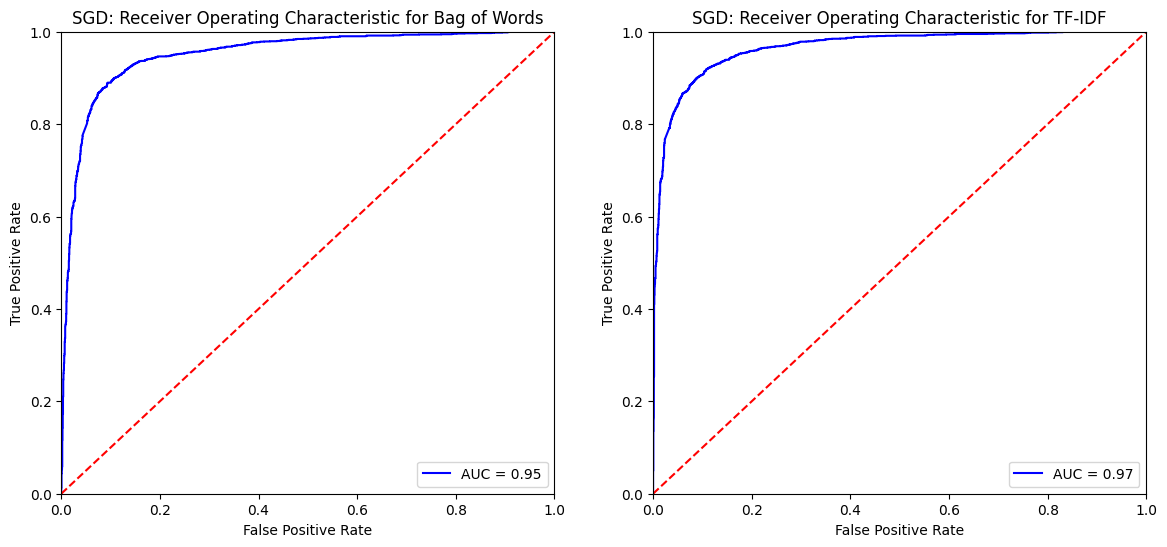

In [72]:
#ROC-AUC curve for bag of words model from the original data
probs2_bow = svm_bow.decision_function(bow_X_test)
fpr_svm_bow, trp_svm_bow, thresholds_svm_bow = roc_curve(y_test, probs2_bow)
roc_auc_svm_bow = auc(fpr_svm_bow, trp_svm_bow)
#ROC-AUC curve for tfidf features
probs2_tfidf = svm_tfidf.decision_function(tfidf_X_test)
fpr_svm_tfidf, trp_svm_tfidf, thresholds_svm_tfidf = roc_curve(y_test, probs2_tfidf)
roc_auc_svm_tfidf = auc(fpr_svm_tfidf, trp_svm_tfidf)

#Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('SGD: Receiver Operating Characteristic for Bag of Words')
plt.plot(fpr_svm_bow, trp_svm_bow, 'b', label = 'AUC = %0.2f' % roc_auc_svm_bow)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('SGD: Receiver Operating Characteristic for TF-IDF')
plt.plot(fpr_svm_tfidf, trp_svm_tfidf, 'b', label = 'AUC = %0.2f' % roc_auc_svm_tfidf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

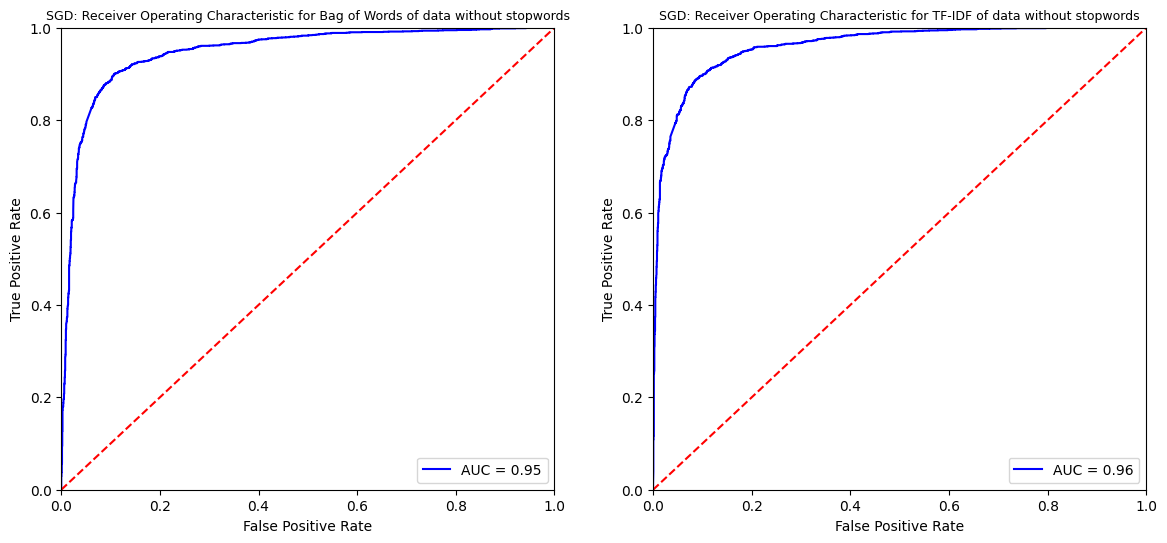

In [73]:
# ROC-AUC curve for bag of words model from the data without stopwords
probs2_bow_ws = svm_bow_ws.decision_function(bow_X_test_ws)
fpr_svm_bow_ws, trp_svm_bow_ws, thresholds_svm_bow_ws = roc_curve(y_test_ws, probs2_bow_ws)
roc_auc_svm_bow_ws = auc(fpr_svm_bow_ws, trp_svm_bow_ws)
# ROC-AUC curve for tfidf features
probs2_tfidf_ws = svm_tfidf_ws.decision_function(tfidf_X_test_ws)
fpr_svm_tfidf_ws, trp_svm_tfidf_ws, thresholds_svm_tfidf_ws = roc_curve(y_test_ws, probs2_tfidf_ws)
roc_auc_svm_tfidf_ws = auc(fpr_svm_tfidf_ws, trp_svm_tfidf_ws)

# Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('SGD: Receiver Operating Characteristic for Bag of Words of data without stopwords', fontsize=9)
plt.plot(fpr_svm_bow_ws, trp_svm_bow_ws, 'b', label = 'AUC = %0.2f' % roc_auc_svm_bow_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('SGD: Receiver Operating Characteristic for TF-IDF of data without stopwords', fontsize=9)
plt.plot(fpr_svm_tfidf_ws, trp_svm_tfidf_ws, 'b', label = 'AUC = %0.2f' % roc_auc_svm_tfidf_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

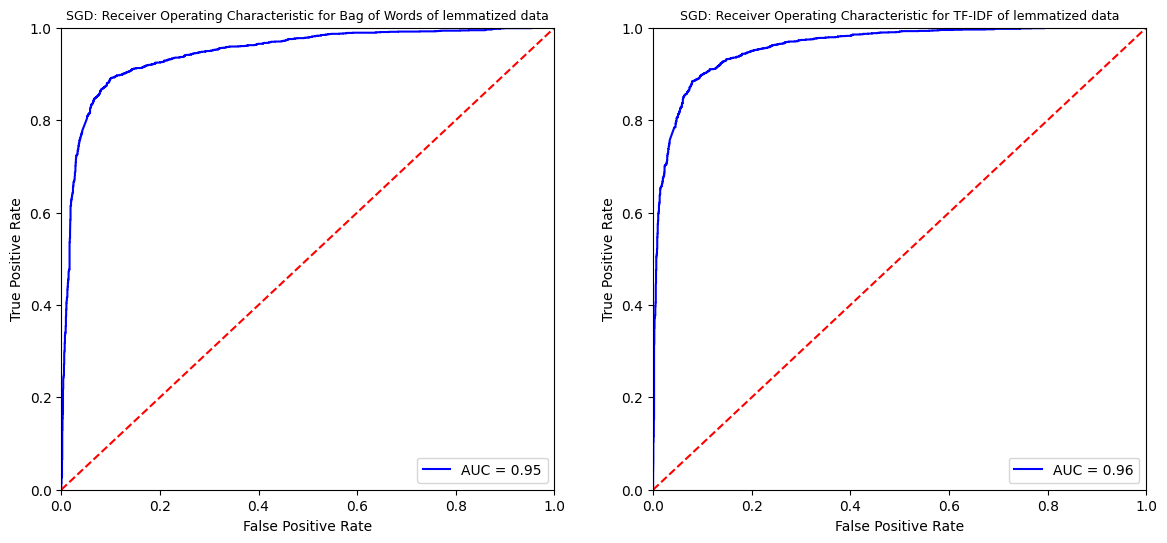

In [74]:
# ROC-AUC curve for bag of words model from the lemmatized data
probs2_bow_lem = svm_bow_lem.decision_function(bow_X_test_lem)
fpr_svm_bow_lem, trp_svm_bow_lem, thresholds_svm_bow_lem = roc_curve(y_test_lem, probs2_bow_lem)
roc_auc_svm_bow_lem = auc(fpr_svm_bow_lem, trp_svm_bow_lem)
# ROC-AUC curve for tfidf features
probs2_tfidf_lem = svm_tfidf_lem.decision_function(tfidf_X_test_lem)
fpr_svm_tfidf_lem, trp_svm_tfidf_lem, thresholds_svm_tfidf_lem = roc_curve(y_test_lem, probs2_tfidf_lem)
roc_auc_svm_tfidf_lem = auc(fpr_svm_tfidf_lem, trp_svm_tfidf_lem)

# Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('SGD: Receiver Operating Characteristic for Bag of Words of lemmatized data', fontsize=9)
plt.plot(fpr_svm_bow_lem, trp_svm_bow_lem, 'b', label = 'AUC = %0.2f' % roc_auc_svm_bow_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('SGD: Receiver Operating Characteristic for TF-IDF of lemmatized data', fontsize=9)
plt.plot(fpr_svm_tfidf_lem, trp_svm_tfidf_lem, 'b', label = 'AUC = %0.2f' % roc_auc_svm_tfidf_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Multinomial Naive Bayes Model**
We use Multinomial because it assumes a feature vector where each element represents the number of times it appears (or its frequency). The Gaussian Naive Bayes, instead, is based on a continuous distribution characterized by mean & variance.

https://scikit-learn.org/1.5/modules/generated/sklearn.naive_bayes.MultinomialNB.html

## **Training**

In [110]:
#training the model
mnb_bow = MultinomialNB()
start13 = perf_counter()
mnb_bow.fit(bow_X_train, y_train.ravel())
end13 = perf_counter()
#fitting the Naive Bayes for tfidf
mnb_tfidf = MultinomialNB()
start14 = perf_counter()
mnb_tfidf.fit(tfidf_X_train, y_train)
end14 = perf_counter()

print(f"Time taken to train MNB model with BOW: {end13-start13:.2f} seconds")
print(f"Time taken to train MNB model with TF-IDF: {end14-start14:.2f} seconds")

Time taken to train MNB model with BOW: 0.05 seconds
Time taken to train MNB model with TF-IDF: 0.04 seconds


In [111]:
# For the data without stopwords
mnb_bow_ws = MultinomialNB()
start15 = perf_counter()
mnb_bow_ws.fit(bow_X_train_ws, y_train_ws)
end15 = perf_counter()
mnb_tfidf_ws = MultinomialNB()
start16 = perf_counter()
mnb_tfidf_ws.fit(tfidf_X_train_ws, y_train_ws)
end16 = perf_counter()

print(f"Time taken to train MNB model with BOW without stopwords: {end15-start15:.2f} seconds")
print(f"Time taken to train MNB model with TF-IDF without stopwords: {end16-start16:.2f} seconds")

Time taken to train MNB model with BOW without stopwords: 0.03 seconds
Time taken to train MNB model with TF-IDF without stopwords: 0.03 seconds


In [112]:
# For the lemmatized data
mnb_bow_lem = MultinomialNB()
start17 = perf_counter()
mnb_bow_lem.fit(bow_X_train_lem, y_train_lem)
end17 = perf_counter()
mnb_tfidf_lem = MultinomialNB()
start18 = perf_counter()
mnb_tfidf_lem.fit(tfidf_X_train_lem, y_train_lem)
end18 = perf_counter()

print(f"Time taken to train MNB model with BOW lemmatized data: {end17-start17:.2f} seconds")
print(f"Time taken to train MNB model with TF-IDF lemmatized data: {end18-start18:.2f} seconds")

Time taken to train MNB model with BOW lemmatized data: 0.02 seconds
Time taken to train MNB model with TF-IDF lemmatized data: 0.03 seconds


## **Validation**

In [78]:
# Validating for original data
cv_bow_mnb = cross_val_score(mnb_bow, bow_X_val, y_val, cv=5)
cv_tfidf_mnb = cross_val_score(mnb_tfidf, tfidf_X_val, y_val, cv=5)

print(f"Cross-validation mean score for BoW in the original data:      {cv_bow_mnb.mean()}")
print(f"Cross-validation mean score for TF-IDF in the original data:   {cv_tfidf_mnb.mean()}")

Cross-validation mean score for BoW in the original data:      0.5701142048135913
Cross-validation mean score for TF-IDF in the original data:   0.7115563945257197


In [79]:
# Validating for data without stopwords
cv_bow_mnb_ws = cross_val_score(mnb_bow_ws, bow_X_val_ws, y_val_ws, cv=5)
cv_tfidf_mnb_ws = cross_val_score(mnb_tfidf_ws, tfidf_X_val_ws, y_val_ws, cv=5)

print(f"Cross-validation mean score for BoW in the data without stopwords:      {cv_bow_mnb_ws.mean()}")
print(f"Cross-validation mean score for TF-IDF in the data without stopwords:   {cv_tfidf_mnb_ws.mean()}")

Cross-validation mean score for BoW in the data without stopwords:      0.5873374233128834
Cross-validation mean score for TF-IDF in the data without stopwords:   0.7552203869749882


In [80]:
# Validating for lemmatized data
cv_bow_mnb_lem = cross_val_score(mnb_bow_lem, bow_X_val_lem, y_val_lem, cv=5)
cv_tfidf_mnb_lem = cross_val_score(mnb_tfidf_lem, tfidf_X_val_lem, y_val_lem, cv=5)

print(f"Cross-validation mean score for BoW in the lemmatized data:      {cv_bow_mnb_lem.mean()}")
print(f"Cross-validation mean score for TF-IDF in the lemmatized data:   {cv_tfidf_mnb_lem.mean()}")

Cross-validation mean score for BoW in the lemmatized data:      0.5818008494572912
Cross-validation mean score for TF-IDF in the lemmatized data:   0.7546031146767345


## **Evaluation**

In [81]:
#Predicting the model for bag of words from the original data
mnb_bow_predict=mnb_bow.predict(bow_X_test)
#Predicting the model for tfidf from the original data
mnb_tfidf_predict=mnb_tfidf.predict(tfidf_X_test)

In [82]:
# Predicting the model for bag of words from the data without stopwords
mnb_bow_ws_predict=mnb_bow_ws.predict(bow_X_test_ws)
# Predicting the model for tfidf from the data without stopwords
mnb_tfidf_ws_predict=mnb_tfidf_ws.predict(tfidf_X_test_ws)

In [83]:
# Predicting the model for bag of words from the lemmatized data
mnb_bow_lem_predict=mnb_bow_lem.predict(bow_X_test_lem)
# Predicting the model for tfidf from the lemmatized data
mnb_tfidf_lem_predict=mnb_tfidf_lem.predict(tfidf_X_test_lem)

### Accuracy

In [84]:
#Accuracy score for bag of words model from the original data
mnb_bow_score=accuracy_score(y_test, mnb_bow_predict)
#Accuracy score for tfidf model from the original data
mnb_tfidf_score=accuracy_score(y_test, mnb_tfidf_predict)

#Printing the accuracy scores
print(f"Accuracy score of the BoW model from the original data:      {mnb_bow_score}")
print(f"Accuracy score of the TF-IDF model from the original data:   {mnb_tfidf_score}")

Accuracy score of the BoW model from the original data:      0.7519074575436869
Accuracy score of the TF-IDF model from the original data:   0.7639675116908689


In [85]:
# Accuracy score for bag of words model from the data without stopwords
mnb_bow_ws_score=accuracy_score(y_test_ws, mnb_bow_ws_predict)
# Accuracy score for tfidf model from the data without stopwords
mnb_tfidf_ws_score=accuracy_score(y_test_ws, mnb_tfidf_ws_predict)
# Printing the accuracy scores
print(f"Accuracy score of the BoW model from the data without stopwords:      {mnb_bow_ws_score}")
print(f"Accuracy score of the TF-IDF model from the data without stopwords:   {mnb_tfidf_ws_score}")

Accuracy score of the BoW model from the data without stopwords:      0.7312330790056608
Accuracy score of the TF-IDF model from the data without stopwords:   0.8018705390105834


In [86]:
# Accuracy score for bag of words model from the lemmatized data
mnb_bow_lem_score=accuracy_score(y_test_lem, mnb_bow_lem_predict)
# Accuracy score for tfidf model from the lemmatized data
mnb_tfidf_lem_score=accuracy_score(y_test_lem, mnb_tfidf_lem_predict)
# Printing the accuracy scores
print(f"Accuracy score of the BoW model from the lemmatized data:      {mnb_bow_lem_score}")
print(f"Accuracy score of the TF-IDF model from the lemmatized data:   {mnb_tfidf_lem_score}")

Accuracy score of the BoW model from the lemmatized data:      0.7462466158011322
Accuracy score of the TF-IDF model from the lemmatized data:   0.7971941914841251


### Classification Report

In [87]:
# Classification report for bag of words model from the original data
mnb_bow_report=classification_report(y_test,mnb_bow_predict,target_names=['Negative','Positive'])
# Classification report for tfidf model from the original data
mnb_tfidf_report=classification_report(y_test,mnb_tfidf_predict,target_names=['Negative','Positive'])
print(f"Multinomial Naive Bayes Classification Report of the Bag of Words Model from the original data: \n{mnb_bow_report} \n\nMultinomial Naive Bayes Classification Report of the TF-IDF Model from the original data: \n{mnb_tfidf_report}")

Multinomial Naive Bayes Classification Report of the Bag of Words Model from the original data: 
              precision    recall  f1-score   support

    Negative       0.67      0.99      0.80      2023
    Positive       0.98      0.52      0.68      2040

    accuracy                           0.75      4063
   macro avg       0.82      0.75      0.74      4063
weighted avg       0.82      0.75      0.74      4063
 

Multinomial Naive Bayes Classification Report of the TF-IDF Model from the original data: 
              precision    recall  f1-score   support

    Negative       0.68      0.99      0.81      2023
    Positive       0.98      0.54      0.70      2040

    accuracy                           0.76      4063
   macro avg       0.83      0.76      0.75      4063
weighted avg       0.83      0.76      0.75      4063



In [88]:
# Classification report for bag of words model from the data without stopwords
mnb_bow_ws_report=classification_report(y_test_ws,mnb_bow_ws_predict,target_names=['Negative','Positive'])
# Classification report for tfidf model from the data without stopwords
mnb_tfidf_ws_report=classification_report(y_test_ws,mnb_tfidf_ws_predict,target_names=['Negative','Positive'])
print(f"Multinomial Naive Bayes Classification Report of the Bag of Words Model from the data without stopwords: \n{mnb_bow_ws_report} \n\nMultinomial Naive Bayes Classification Report of the TF-IDF Model from the data without stopwords: \n{mnb_tfidf_ws_report}")

Multinomial Naive Bayes Classification Report of the Bag of Words Model from the data without stopwords: 
              precision    recall  f1-score   support

    Negative       0.65      0.99      0.79      2023
    Positive       0.98      0.48      0.64      2040

    accuracy                           0.73      4063
   macro avg       0.81      0.73      0.71      4063
weighted avg       0.81      0.73      0.71      4063
 

Multinomial Naive Bayes Classification Report of the TF-IDF Model from the data without stopwords: 
              precision    recall  f1-score   support

    Negative       0.72      0.98      0.83      2023
    Positive       0.97      0.62      0.76      2040

    accuracy                           0.80      4063
   macro avg       0.85      0.80      0.80      4063
weighted avg       0.85      0.80      0.80      4063



In [89]:
# Classification report for bag of words model from the lemmatized data
mnb_bow_lem_report=classification_report(y_test_lem,mnb_bow_lem_predict,target_names=['Negative','Positive'])
# Classification report for tfidf model from the lemmatized data
mnb_tfidf_lem_report=classification_report(y_test_lem,mnb_tfidf_lem_predict,target_names=['Negative','Positive'])
print(f"Multinomial Naive Bayes Classification Report of the Bag of Words Model from the lemmatized data: \n{mnb_bow_lem_report} \n\nMultinomial Naive Bayes Classification Report of the TF-IDF Model from the lemmatized data: \n{mnb_tfidf_lem_report}")

Multinomial Naive Bayes Classification Report of the Bag of Words Model from the lemmatized data: 
              precision    recall  f1-score   support

    Negative       0.66      0.99      0.80      2023
    Positive       0.98      0.51      0.67      2040

    accuracy                           0.75      4063
   macro avg       0.82      0.75      0.73      4063
weighted avg       0.82      0.75      0.73      4063
 

Multinomial Naive Bayes Classification Report of the TF-IDF Model from the lemmatized data: 
              precision    recall  f1-score   support

    Negative       0.72      0.98      0.83      2023
    Positive       0.97      0.62      0.75      2040

    accuracy                           0.80      4063
   macro avg       0.84      0.80      0.79      4063
weighted avg       0.84      0.80      0.79      4063



### Confusion Matrix

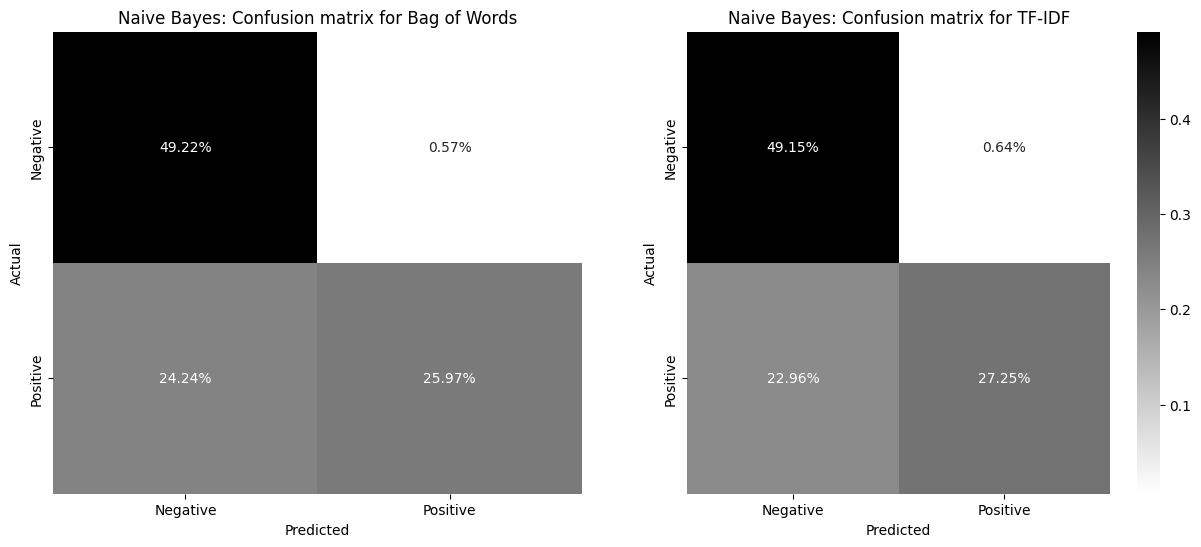

In [90]:
# For the original data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm3_bow=confusion_matrix(y_test, mnb_bow_predict)
# create heatmap
sns.heatmap(cm3_bow/np.sum(cm3_bow), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Naive Bayes: Confusion matrix for Bag of Words')

cm3_tfidf=confusion_matrix(y_test, mnb_tfidf_predict)
sns.heatmap(cm3_tfidf/np.sum(cm3_tfidf), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Naive Bayes: Confusion matrix for TF-IDF')

plt.show()

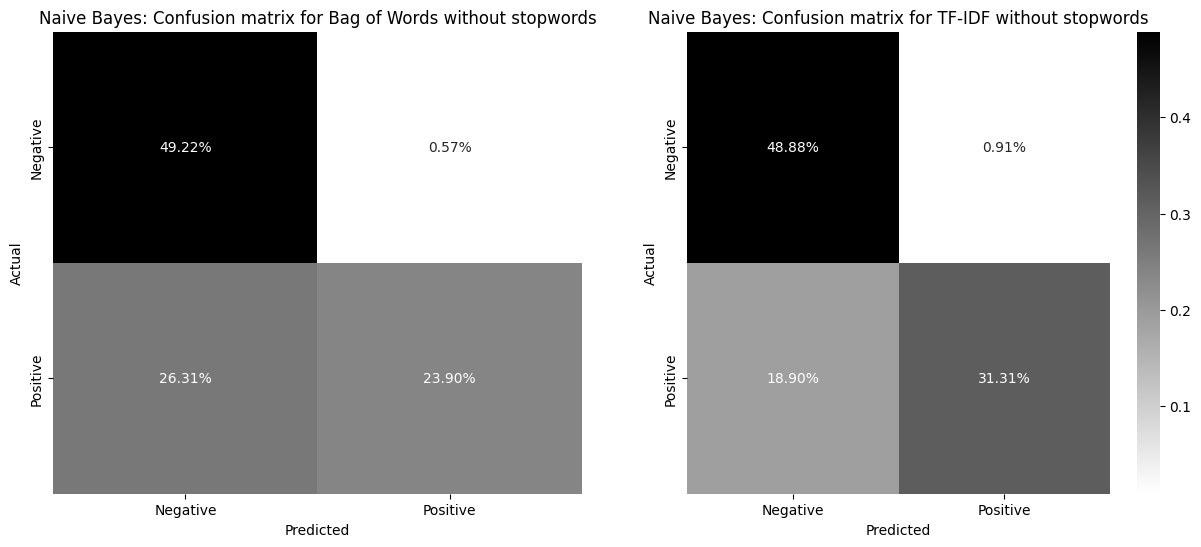

In [91]:
# For the data without stopwords
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm3_bow_ws=confusion_matrix(y_test_ws, mnb_bow_ws_predict)
# create heatmap
sns.heatmap(cm3_bow_ws/np.sum(cm3_bow_ws), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Naive Bayes: Confusion matrix for Bag of Words without stopwords')

cm3_tfidf_ws=confusion_matrix(y_test_ws, mnb_tfidf_ws_predict)
sns.heatmap(cm3_tfidf_ws/np.sum(cm3_tfidf_ws), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Naive Bayes: Confusion matrix for TF-IDF without stopwords')

plt.show()

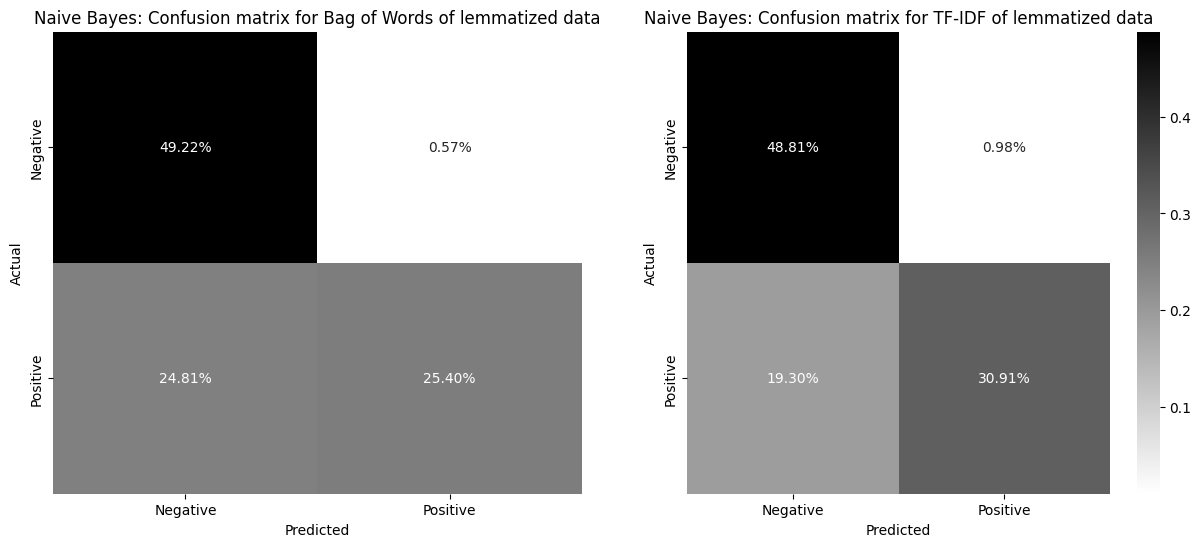

In [92]:
# For the lemmatized data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm3_bow_lem=confusion_matrix(y_test_lem, mnb_bow_lem_predict)
# create heatmap
sns.heatmap(cm3_bow_lem/np.sum(cm3_bow_lem), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Naive Bayes: Confusion matrix for Bag of Words of lemmatized data')

cm3_tfidf_lem=confusion_matrix(y_test_lem, mnb_tfidf_lem_predict)
sns.heatmap(cm3_tfidf_lem/np.sum(cm3_tfidf_lem), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Naive Bayes: Confusion matrix for TF-IDF of lemmatized data')

plt.show()

### **ROC Curves**
- https://stackoverflow.com/questions/33228876/cant-generate-roc-auc-curve-from-naive-bayes-classifier
- https://scikit-learn.org/1.5/modules/generated/sklearn.naive_bayes.MultinomialNB.html

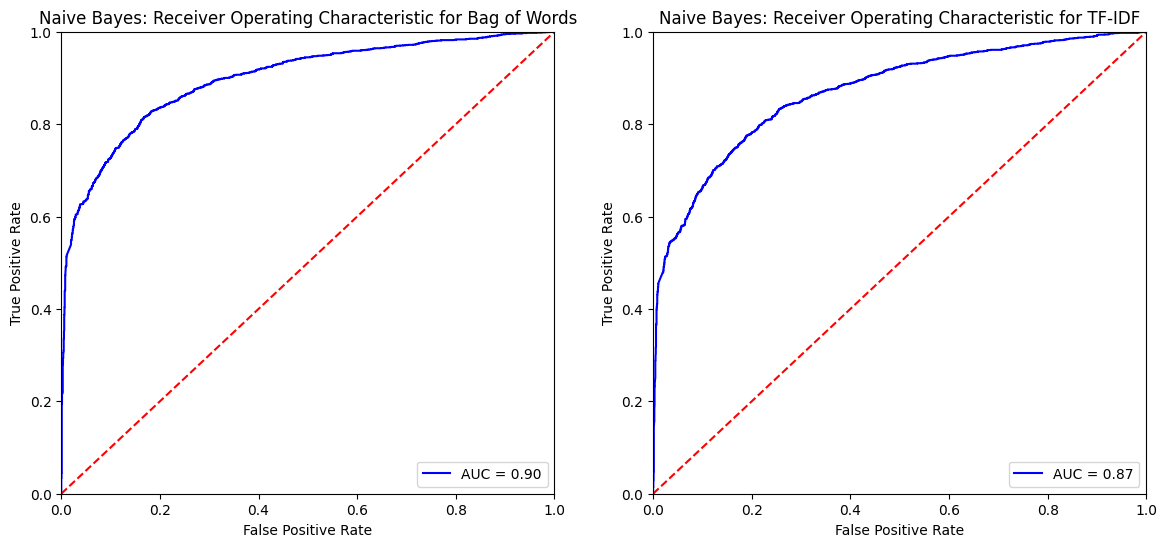

In [93]:
#ROC-AUC curve for bag of words
probs_bow3 = mnb_bow.predict_proba(bow_X_test)
preds_bow3 = probs_bow3[:,1]
fpr_mnb_bow, trp_mnb_bow, thresholds_mnb_bow = roc_curve(y_test, preds_bow3)
roc_auc_mnb_bow = auc(fpr_mnb_bow, trp_mnb_bow)
#ROC-AUC curve for tfidf features
probs_tfidf3 = mnb_tfidf.predict_proba(bow_X_test)
preds_tfidf3 = probs_tfidf3[:,1]
fpr_mnb_tfidf, trp_mnb_tfidf, thresholds_mnb_tfidf = roc_curve(y_test, preds_tfidf3)
roc_auc_mnb_tfidf = auc(fpr_mnb_tfidf, trp_mnb_tfidf)

#Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('Naive Bayes: Receiver Operating Characteristic for Bag of Words')
plt.plot(fpr_mnb_bow, trp_mnb_bow, 'b', label = 'AUC = %0.2f' % roc_auc_mnb_bow)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('Naive Bayes: Receiver Operating Characteristic for TF-IDF')
plt.plot(fpr_mnb_tfidf, trp_mnb_tfidf, 'b', label = 'AUC = %0.2f' % roc_auc_mnb_tfidf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

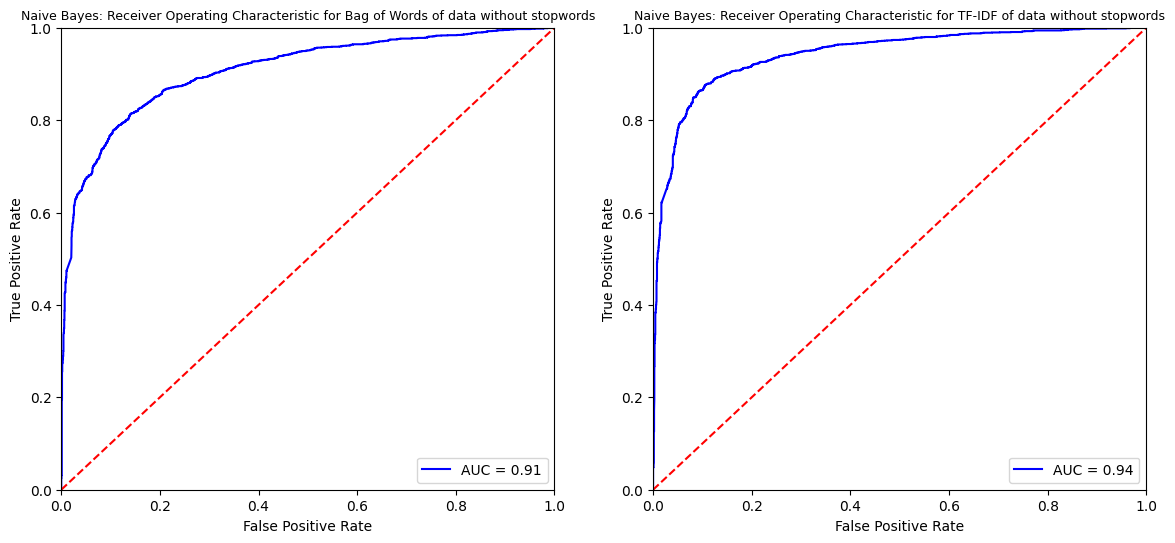

In [94]:
# ROC-AUC curve for bag of words model from the data without stopwords
probs3_bow_ws = mnb_bow_ws.predict_proba(bow_X_test_ws)
preds3_bow_ws = probs3_bow_ws[:,1]
fpr_mnb_bow_ws, trp_mnb_bow_ws, thresholds_mnb_bow_ws = roc_curve(y_test_ws, preds3_bow_ws)
roc_auc_mnb_bow_ws = auc(fpr_mnb_bow_ws, trp_mnb_bow_ws)
# ROC-AUC curve for tfidf features
probs3_tfidf_ws = mnb_tfidf_ws.predict_proba(tfidf_X_test_ws)
preds3_tfidf_ws = probs3_tfidf_ws[:,1]
fpr_mnb_tfidf_ws, trp_mnb_tfidf_ws, thresholds_mnb_tfidf_ws = roc_curve(y_test_ws, preds3_tfidf_ws)
roc_auc_mnb_tfidf_ws = auc(fpr_mnb_tfidf_ws, trp_mnb_tfidf_ws)

# Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('Naive Bayes: Receiver Operating Characteristic for Bag of Words of data without stopwords', fontsize=9)
plt.plot(fpr_mnb_bow_ws, trp_mnb_bow_ws, 'b', label = 'AUC = %0.2f' % roc_auc_mnb_bow_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('Naive Bayes: Receiver Operating Characteristic for TF-IDF of data without stopwords', fontsize=9)
plt.plot(fpr_mnb_tfidf_ws, trp_mnb_tfidf_ws, 'b', label = 'AUC = %0.2f' % roc_auc_mnb_tfidf_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

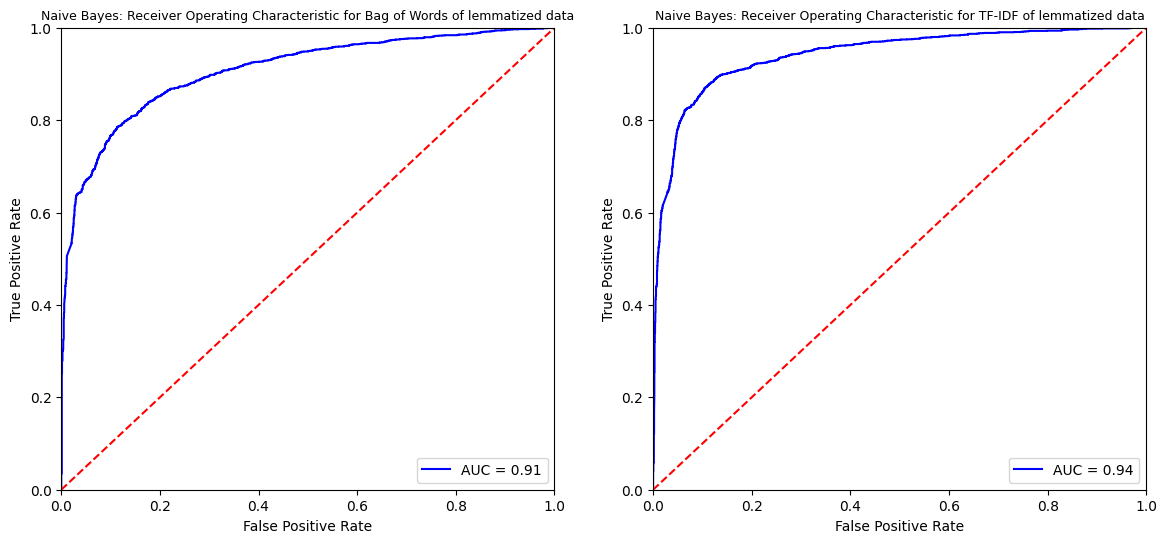

In [95]:
# ROC-AUC curve for bag of words model from the lemmatized data
probs3_bow_lem = mnb_bow_lem.predict_proba(bow_X_test_lem)
preds3_bow_lem = probs3_bow_lem[:,1]
fpr_mnb_bow_lem, trp_mnb_bow_lem, thresholds_mnb_bow_lem = roc_curve(y_test_lem, preds3_bow_lem)
roc_auc_mnb_bow_lem = auc(fpr_mnb_bow_lem, trp_mnb_bow_lem)
# ROC-AUC curve for tfidf features
probs3_tfidf_lem = mnb_tfidf_lem.predict_proba(tfidf_X_test_lem)
preds3_tfidf_lem = probs3_tfidf_lem[:,1]
fpr_mnb_tfidf_lem, trp_mnb_tfidf_lem, thresholds_mnb_tfidf_lem = roc_curve(y_test_lem, preds3_tfidf_lem)
roc_auc_mnb_tfidf_lem = auc(fpr_mnb_tfidf_lem, trp_mnb_tfidf_lem)

# Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('Naive Bayes: Receiver Operating Characteristic for Bag of Words of lemmatized data', fontsize=9)
plt.plot(fpr_mnb_bow_lem, trp_mnb_bow_lem, 'b', label = 'AUC = %0.2f' % roc_auc_mnb_bow_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('Naive Bayes: Receiver Operating Characteristic for TF-IDF of lemmatized data', fontsize=9)
plt.plot(fpr_mnb_tfidf_lem, trp_mnb_tfidf_lem, 'b', label = 'AUC = %0.2f' % roc_auc_mnb_tfidf_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()